# **CSC14120 - PARALLEL PROGRAMMING** - *FINAL PROJECT*

#### **Team Plan and Work Distribution** 
**Group:** 8
| Student ID | Name | Task |
| --- | --- | --- |
| 22127029 | Lê Nguyễn Gia Bảo  | Data Pipeline + SVM Integration + Video |
| 22127249 | Trần Thanh Long | CPU Baseline Implementation + GPU Optimization Version 2 + Revise |
| 22127302 | Nguyễn Đăng Nhân | GPU Basic Implementation + GPU Optimization Version 1 + Report |


# **Section 1: Problem Description**

## 1. Problem Statement
* Clearly define the image classification task
* Describe the motivation for GPU acceleration

#### Clearly define the image classification task
- The core objective of this project is to build an Autoemcoder-based unsupervised feature learning system for image classification on the CIFAR-10 dataset.This process is implemented in a two-stage pipeline:
- Stage 1 - Unsupervised Feature Learning:
  - Train a Convolutional Autoencoder to reconstruct $32 \times 32 \times 3$ input images from CIFAR-10.
  - The Autoencoder learns to compress the image into an 8,192-dimensional feature representation.
  - The network is trained to minimize the reconstruction error (MSE Loss), forcing the encoder to capture essential visual patterns (edges, textures, shapes) without using any class labels
- Stage 2 - Supervised Classification:
  - Use the trained encoder to extract features for all images. Then, a Support Vector Machine (SVM) classifier is trained on these learned features using the class labels.
  - The final performance is evaluated on the test set.
- Dataset and Performance TargetDataset: CIFAR-10 (60,000 total images, $32 \times 32$ pixels, 10 classes).
- Target Accuracy: The project aims for a Test classification accuracy of 60-65%.

#### Describe the motivation for GPU acceleration
- The primary motivation for implementing the project's core components (Autoencoder training and feature extraction) in CUDA is to overcome CPU performance limitations and meet aggressive time targets.
- Training the Convolutional Autoencoder is a computationally intensive task that can take hours on a CPU. The goal is to reduce the Autoencoder training time to less than 10 minutes on the GPU.
- Through systematic optimization, the project aims to accelerate the autoencoder dramatically, targeting a GPU speedup over CPU of >20x.
- The process of running the encoder to extract features for all 60,000 images must also be highly optimized, with a target Feature extraction time of less than 20 seconds.
- The project's main focus is on implementing and optimizing the autoencoder training and inference in CUDA, while utilizing existing optimized libraries (like LIBSVM) for the subsequent SVM classification step.

## 2. CIFAR-10 Dataset Overview
* Dataset specifications (size, classes, split)
* Show sample images from each class (use visualization)
* Explain data preprocessing steps (normalization, format)

#### **Dataset Specifications**

The dataset is prized for its manageable size, allowing researchers to quickly iterate on different neural network architectures.

| Feature | Specification |
| --- | --- |
| **Total Images** | 60,000 |
| **Image Resolution** | 32 x 32 pixels |
| **Color Channels** | 3 (RGB) |
| **Format** | Color (uint8) |
| **File Size** | ~162 MB (binary version) |

#### **Classes**

The dataset contains 10 distinct classes, with exactly 6,000 images per class. The classes are completely mutually exclusive .

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

#### **Data Split**

The 60,000 images are split into two main subsets to ensure standardized benchmarking:

* **Training Set (50,000 images):** Divided into 5 training batches, each containing 10,000 images. While the total training set is balanced (5,000 images per class), individual batches may have a slightly different distribution.
* **Test Set (10,000 images):** Contains exactly 1,000 randomly selected images from each class.

#### **Sample Image**

In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
!tar -xzf cifar-10-binary.tar.gz
!ls cifar-10-batches-bin/

--2025-12-27 23:02:00--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: 'cifar-10-binary.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  103K 26m52s
    50K .......... .......... .......... .......... ..........  0%  739K 15m18s
   100K .......... .......... .......... .......... ..........  0%  255K 13m49s
   150K .......... .......... .......... .......... ..........  0% 2.39M 10m38s
   200K .......... .......... .......... .......... ..........  0%  256K 10m40s
   250K .......... .......... .......... .......... ..........  0% 1.76M 9m8s
   300K .......... .......... .......... .......... ..........  0% 1.53M 8m5s
   350K .......... .......... .......... .......... ..........  0% 3.55M 7m10s
  

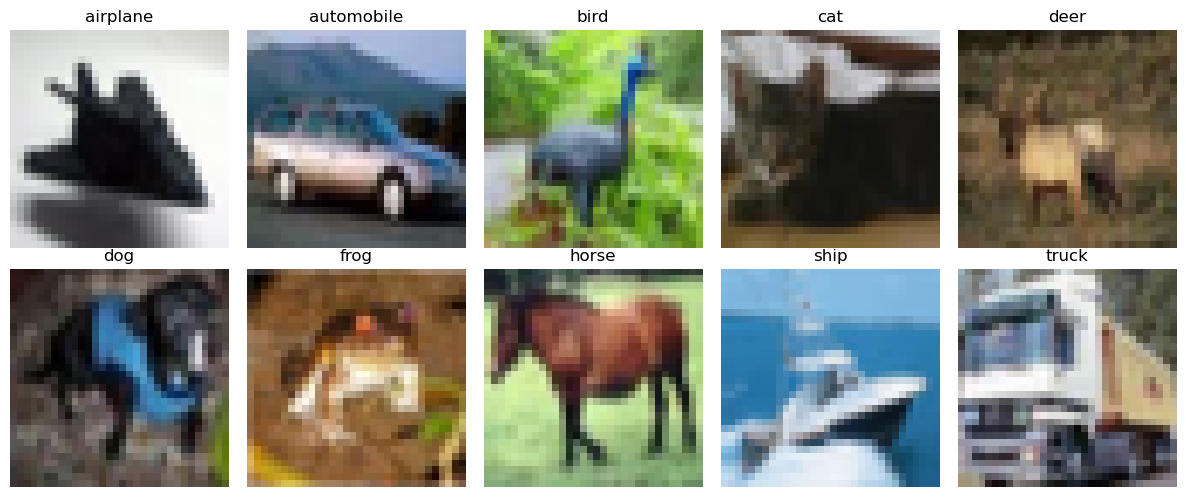

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def load_all_from_bin(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images = data[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

all_imgs, all_lbls = load_all_from_bin('./cifar-10-batches-bin/data_batch_1.bin')

unique_indices = [np.where(all_lbls == i)[0][0] for i in range(10)]

imgs = all_imgs[unique_indices]
lbls = all_lbls[unique_indices]

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.title(f"{class_names[lbls[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### **Data preprocessing steps**

There are three main stages

**1. Structural Parsing and Memory Management**

The process begins by reading the raw binary files into system memory to separate the labels from the pixel data.

* Each image in the CIFAR-10 binary format is stored as a 3073-byte record, where the first byte is the label and the remaining 3072 bytes are the image data.
* The code iterates through the raw buffer, extracting the first byte of every record and storing it into an integer array (`labels`).
* The pixel data (3072 bytes per image) is copied into a separate `raw_images` buffer, effectively stripping the labels to prepare for batch processing on the GPU.

**2. GPU-Accelerated Normalization**

The core of the preprocessing is the normalization step, which shifts pixel values from an integer range to a floating-point range for better gradient flow during training.

* Converts the input `uint8` (0–255) pixel values into `float32`.
* A specific GPU function, `normalizeKernel`, is launched where each thread processes a single pixel to compute output[idx] = input[idx] / 255.0f.
* This result ensures all input features are scaled to the range [0.0, 1.0], which is verified at the end of the loading process by calculating the minimum and maximum values in the final array.
* If a CUDA-enabled device is not detected, the code includes a nested loop fallback to perform the same division on the CPU.

**3. Dataset Organization and Shuffling**

Once the data is normalized, it is organized into a structured `Dataset` object for easier handling by the training loop.

* The `shuffle_dataset` function uses a Mersenne Twister random number generator (`mt19937`) to shuffle an index vector. It then rearranges the image and label memory based on these random indices to ensure the model does not learn the order of the classes.
* The `create_minibatches` function partitions the full dataset into smaller, fixed-size `Dataset` objects (batches). This allows the training process to perform weight updates more frequently and manage memory more efficiently.

## 3. Autoencoder Architecture
* Describe the network architecture with a diagram
* Specify layer dimensions and transformations
* Explain the encoder-decoder structure and latent representation
* Include architecture visualization

#### **Network Architecture**

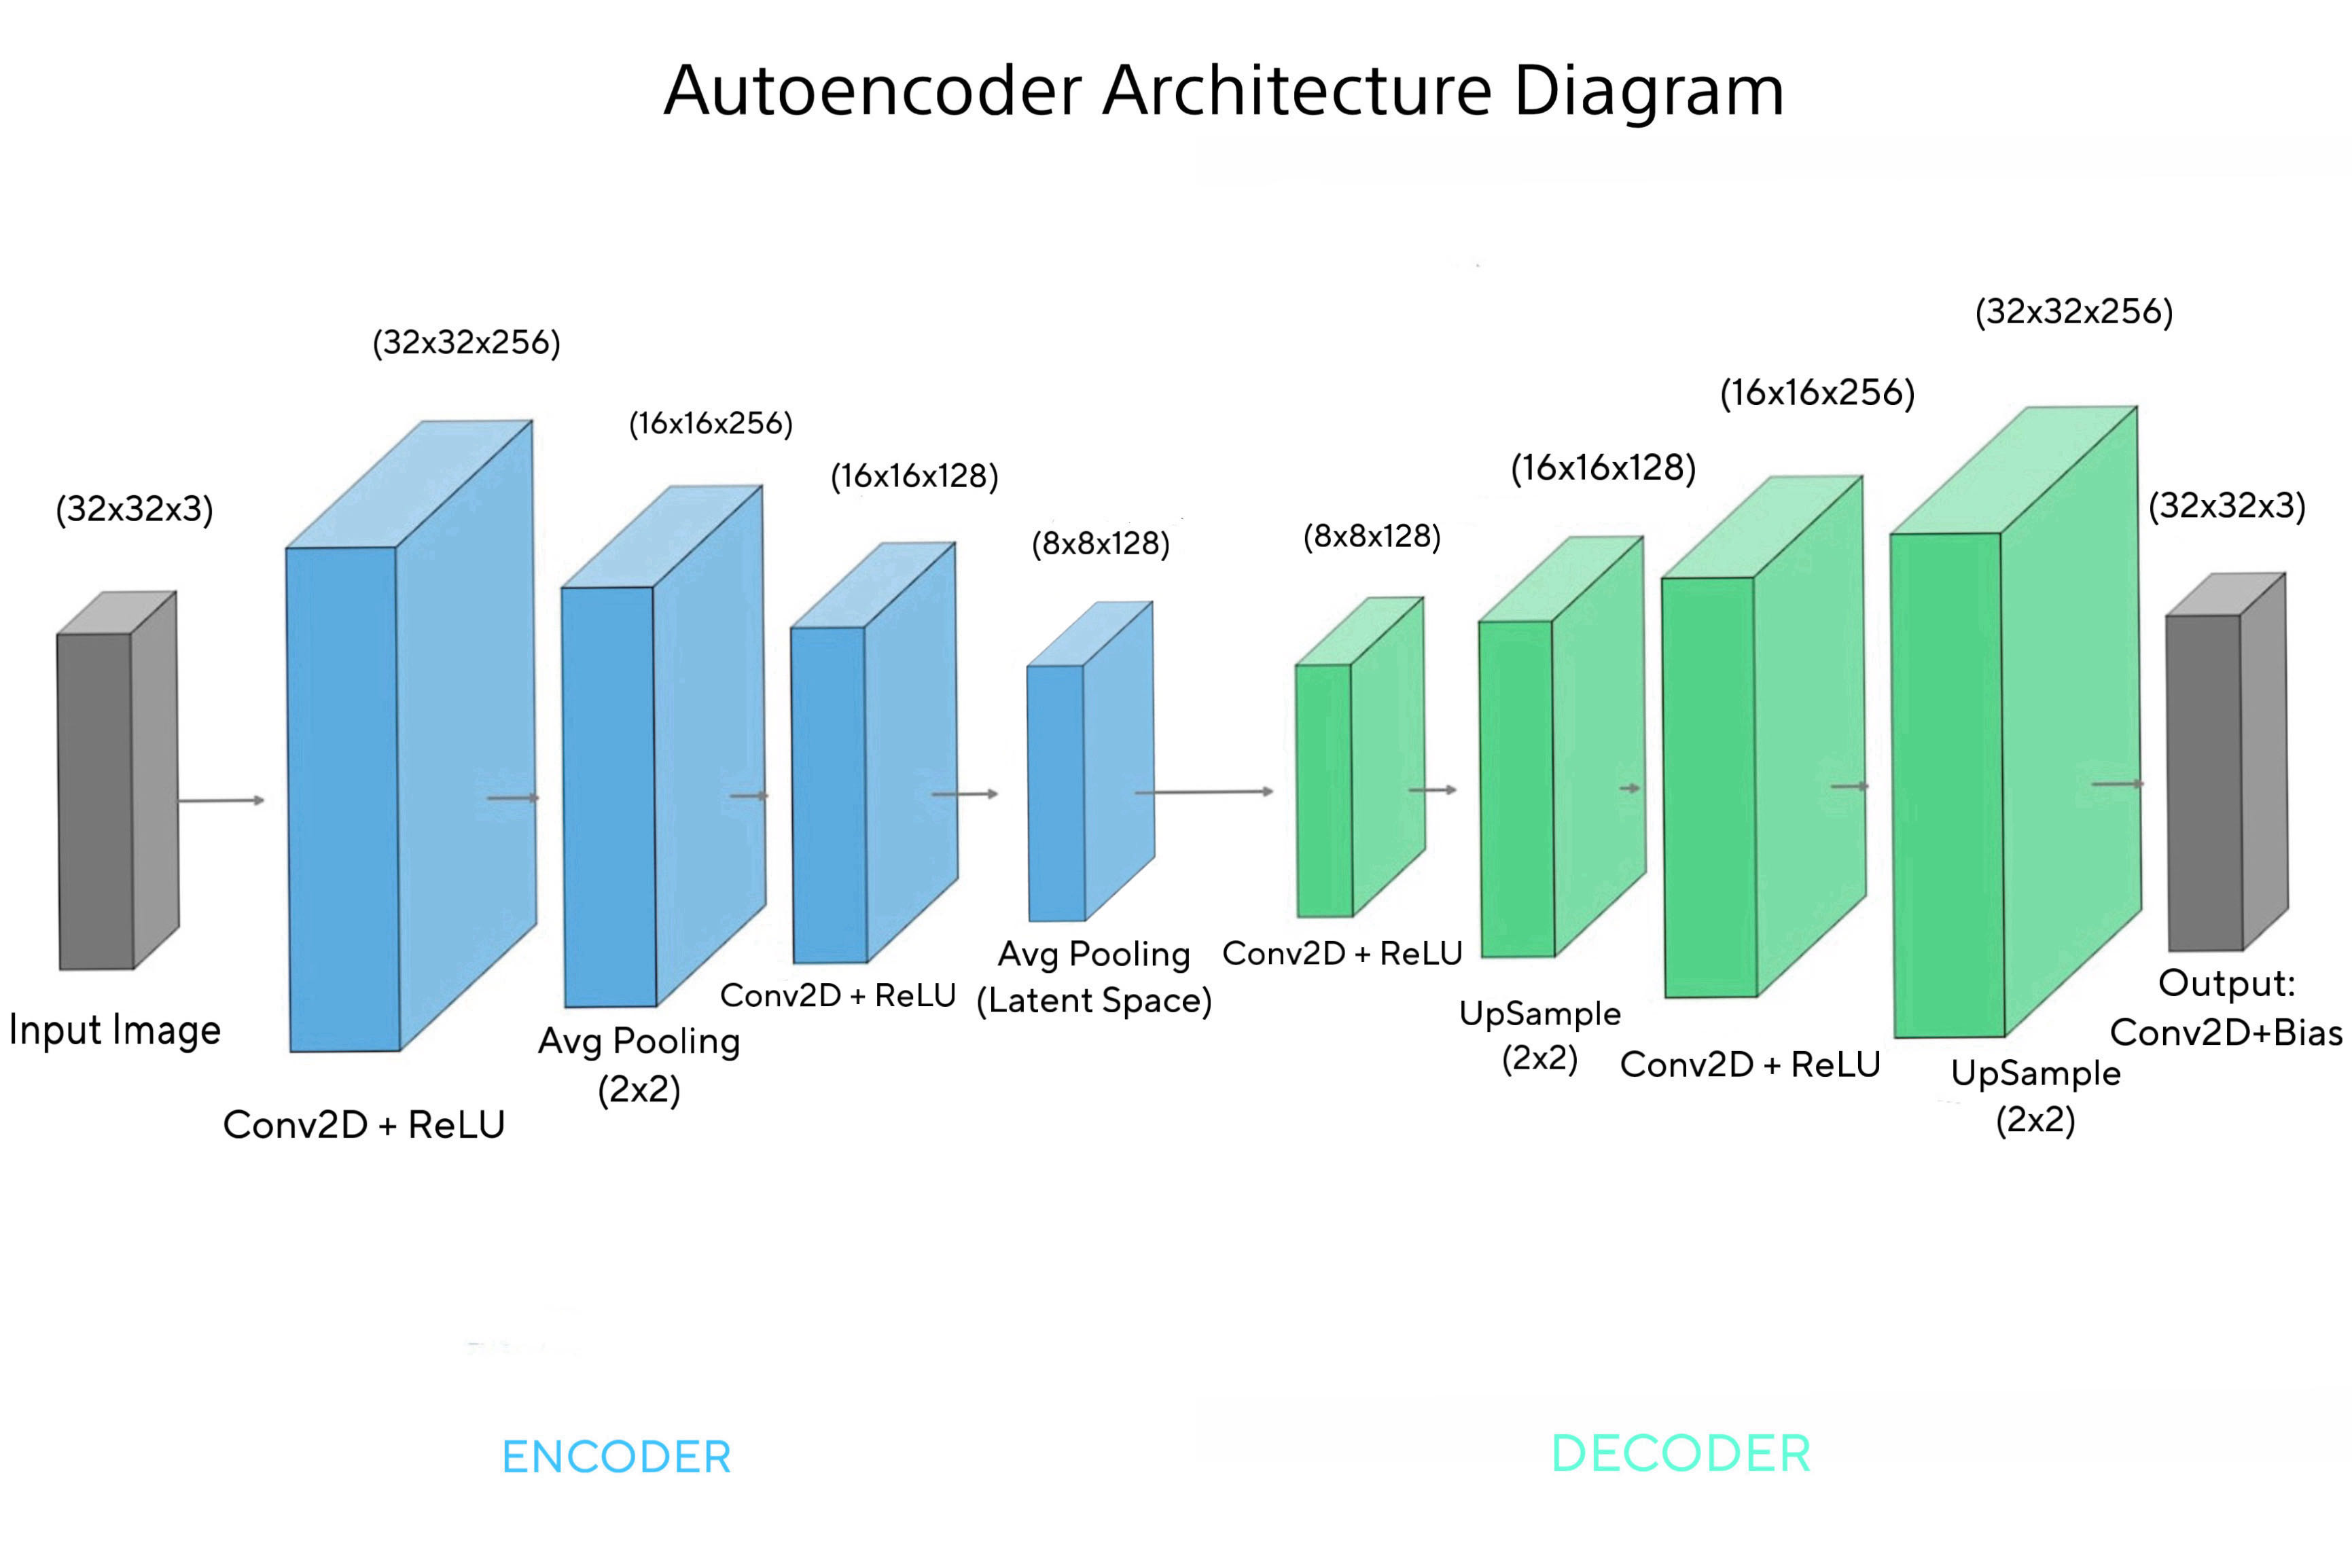

#### **Encoder Structure**

* The encoder reduces the spatial dimensions (width and height) of the input image while increasing feature depth to extract high-level patterns.
* **Spatial Compression**: It uses a sequence of convolutional and **max pooling** layers to shrink the input. The code explicitly implements `cpu_max_pooling`, which reduces the width and height by a factor of 2 at each stage.
* **Layer 1**: Input  Conv  ReLU  Max Pool (Size ).
* **Layer 2**: Input  Conv  ReLU  Max Pool (Size ).



#### **Latent Representation**

* The latent representation is the output of the second encoder layer, serving as the compressed "bottleneck" of the network.
* The spatial resolution is reduced to  of the original input, containing the most essential features in a condensed format.

#### **Decoder Structure**

* The decoder attempts to reconstruct the original input from the latent representation by reversing the compression.
* **Spatial Expansion**: It utilizes upsampling layers to restore spatial dimensions. Each upsampling stage doubles the width and height, effectively undoing the compression performed by the pooling layers.
* **Layer 1**: Latent  Conv  ReLU  Upsample (Size ).
* **Layer 2**: Input  Conv  ReLU  Upsample (Size ).



#### **Layer Dimensions and Transformations**

The CPU implementation defines several core transformations that modify data dimensions as it passes through the network.

| Layer Type | Forward Transformation Logic | Spatial Change |
| --- | --- | --- |
| **Conv2D** | Applies filters to extract features; maintains spatial dimensions via zero-padding logic implicitly handled in the loops. | No Change |
| **ReLU** | Element-wise activation: . | No Change |
| **Max Pooling** | A  window selects the **maximum** value to propagate, discarding the rest. | Dimension  |
| **Upsample** | A single pixel is duplicated into a  output block (Nearest Neighbor interpolation). | Dimension  |

#### **Architecture Visualization**

The overall architecture follows a symmetrical flow of compression and expansion:

1. **Input Layer**: Original image data ().
2. **Encoder Stages**:
* `cpu_conv2D`  `cpu_relu`
* `cpu_max_pooling` (Reduces  by half).


3. **Latent Representation**: The final compressed feature map ().
4. **Decoder Stages**:
* `cpu_conv2D`  `cpu_relu`
* `cpu_upsampling` (Doubles ).


5. **Output Layer**:
* `cpu_conv2D`  `cpu_add_bias` (Reconstructed data matching input size).



## 4. Project Objectives
* Performance goals (training time, speedup targets, accuracy)
* Technical learning objectives
* Success criteria

#### Performance Goals

- These are the required numerical targets must achieve through systematic optimization in CUDA. Achieving these goals is the primary measure of success for the project's performance aspect.

| Metric | Target |
| :--- | :--- |
| **Autoencoder training time** | **<10 minutes** |
| **Feature extraction time** | **<20 seconds** (for all 60,000 images)  |
| **Test classification accuracy** | **60-65%**  |
| **GPU speedup over CPU** | **>20x**  |





#### **Technical Learning Objectives**

- The project serves as an intensive exercise in parallel programming and deep learning implementation by requiring implementation from the ground up.
* Learn to design, implement, and debug efficient parallel kernels for deep learning primitives, including Convolution , ReLU , Max Pooling , and UpSampling.
* Understand and apply advanced optimization techniques (e.g., Shared Memory Tiling, Kernel Fusion, Memory Coalescing, Multi-Stream Pipeline) to maximize GPU efficiency and memory bandwidth utilization.
* Gain a comprehensive understanding of the Autoencoder architecture (forward and backward passes) and implement the complete network from scratch.
* Successfully integrate the high-speed CUDA-accelerated feature extractor with a standard machine learning library (LIBSVM) to complete the two-stage feature learning and classification pipeline.

#### **Success Criteria**

Project success is evaluated by the functional completeness of the pipeline and the achievement of the specified targets.

1. All GPU layer implementations must be verified against the CPU baseline implementation to ensure mathematical accuracy.
2. All quantitative targets for training time, feature extraction time, and GPU speedup must be met or exceeded.
3.  The final classification accuracy on the test set must fall within the target range of **60-65%**, validating the quality of the learned features.
4.  Deliver a detailed, executable Jupyter Notebook report documenting the progressive optimization phases, profiling analysis, results, and key lessons learned.

# Section 2: Implementation Phases

## Phase 2.1: CPU Baseline Implementation

### Objectives:
* What you aimed to achieve in this phase
* Why this phase is necessary

#### **What you aimed to achieve in this phase**
- The aim of Phase 2.1 is to build a complete, functional, and measurable CPU implementation of the entire data pipeline and neural network architecture.
- Data Pipeline Completion: Successfully implement the data loading process for CIFAR-10, including parsing the binary format, normalizing pixel values from [0,255] to [0,1], implementing batch generation, and adding data shuffling.
- CPU Layer Implementation: Create CPU versions of all necessary operations for the Autoencoder: Convolution (Conv2D), ReLU Activation, Max Pooling, Upsampling (Nearest Neighbor interpolation), and MSE Loss.
- Full Autoencoder Functionality: Encapsulate the network architecture into an Autoencoder class, implement weight initialization, manage memory for intermediate activations, and develop the full Forward Pass and Backward Pass (including gradient calculation and weight update logic).
- Establish Baseline Performance: Run the full CPU training loop for a set number of epochs to measure and track the time per epoch and the total training time, thereby establishing the crucial baseline performance.



#### **Why This Phase is Necessary**
- The CPU baseline is not just an intermediary step; it is critical for validating the entire project moving forward.
- The CPU implementation serves as the indispensable "gold standard" reference. Before any optimization, the complex GPU kernels developed in Phase 2 must be verified against the CPU output to ensure they are mathematically accurate and producing the correct results for the forward and backward passes.
- The measured CPU training time is the benchmark against which all subsequent GPU optimization phases are measured. Without a verifiable CPU baseline, you cannot calculate the required >20× speedup target.
- It allows for debugging the high-level neural network logic (weight updates, backpropagation chain, hyperparameter settings) in a familiar CPU environment before dealing with the added complexity of parallel execution and GPU memory management (host/device transfers).

#### **Implementation Details:**
* Data Pipeline: How you loaded and pre-processed CIFAR-10 data
* Layer Implementations: Brief description of each layer (Conv2D, ReLU,
MaxPool, Upsample)
* Training Loop: How you structured the training process
* Key Code Snippets: Show 2-3 critical functions (e.g., convolution function
signature and main loop structure)

#### **Data Pipeline:**
- The data is loaded from the standard CIFAR-10 binary format, where each record contains 1 byte for the label followed by 3072 bytes for the image (32 (width) x 32 (height) x 3 (depth)).
  - Training Data: Loaded from five separte batch files (data_batch_1.bin through data_batch_5.bin), totaling 50.000 samples.
  - Test Data: Loaded from a single test_batch.bin file, totaling 10.000 samples.
  - Dataset Structure: The loaded and pre-processed data is stored in a Dataset object, which manages the image data and labels using `unique_ptr` for memory safety.
- The raw unsigned char pixel values, which range from [0,255], are normalized to float values in the range [0,1].
  - CPU Normlization (Fallback): If CUDA is unavailable, the normalization is performed on the CPU using a standard loop:
  $\text{output}[\text{idx}] = \text{input}[\text{idx}] / 255.0\text{f}$.
  - CUDA Normalization (Default): If a CUDA device is detected, the normalization is offloaded to the GPU for parallel processing.
    - Raw image data is copied to the device
    - A CUDA kernel is launched to perform the $\text{value} / 255.0\text{f}$ calculation in parallel across all pixels .
    - The resulting normalized float data is copied back to the host memory.
- Two ultilities are available to manage the data during the training process:
  - The `shuffle_dataset` function shuffles the order of images and their corresponding labels by shuffling a list of indices and then copying the data based on the index order.
  - The `create_minibatches` function splits the full Dataset into a vector of smalles Dataset objects for efficient stochastic training.

#### **Layers Implementations**

**I. Forward Pass Layers (Inference)**

These functions process the input data to generate predictions or latent representations.

**1. Conv2D (Convolution)**

* **Goal**: Extracts features by sliding filters over the input image.
* **Mechanism**: Iterates through every pixel and every filter. It calculates the weighted sum (dot product) of the filter weights and the corresponding input patch.
* **Padding**: Simulates "same" padding by checking boundary conditions (`if (row < 0 || row >= height) continue`) to keep output dimensions consistent with input.

**2. Add Bias**

* **Goal**: Shifts the output of the convolution by adding a learnable bias parameter.
* **Mechanism**: Adds a specific bias value to every pixel in a specific depth channel. `out[i] = in[i] + bias_val`.

**3. ReLU (Activation)**

* **Goal**: Introduces non-linearity by removing negative values.
* **Mechanism**: Performs element-wise comparison: .

**4. Max Pooling (Downsampling)**

* **Goal**: Reduces spatial dimensions () by half to compress data and keep prominent features.
* **Mechanism**: Scans  regions of the input and selects the **maximum** value to pass to the output. `out_offset[...] = max_val`.

**5. Upsampling (Upsampling)**

* **Goal**: Doubles the spatial dimensions () to reconstruct the image.
* **Mechanism**: Takes a single pixel value and duplicates it into a  block in the output (Nearest Neighbor interpolation).


**II. Loss Calculation**

**6. MSE Loss**

* **Goal**: Measures how far the model's output is from the original input.
* **Mechanism**: Calculates the Mean Squared Error: .


**III. Backward Pass Layers (Training)**

These functions calculate gradients to update weights and propagate errors.

**7. MSE Gradient**

* **Goal**: Starts backpropagation by calculating the derivative of the loss.
* **Mechanism**: Computes gradient per pixel: .

**8. ReLU Backward**

* **Goal**: Passes gradients through the activation function.
* **Mechanism**: Acts as a gate. If the original input was positive (`in > 0`), it passes the gradient (`d_out`) through. If negative, it blocks the gradient (sets to 0).

**9. Max Pooling Backward**

* **Goal**: Routes gradients back through the max pooling layer.
* **Mechanism**: Re-scans the input to find which pixel was the "winner" (max value). The gradient is added **only** to that specific index (`d_in_offset[max_idx] += grad`), while neighbors get 0.

**10. Upsampling Backward**

* **Goal**: Handles gradients for the upsampling layer.
* **Mechanism**: Since one input pixel created 4 output pixels (), this sums the gradients from those 4 output pixels to compute the single input gradient.

**11. Bias Gradient**

* **Goal**: Computes gradients for bias updates.
* **Mechanism**: Sums the gradients (`d_out`) across all spatial pixels () and all images in the batch () for each specific channel.

**12. Conv2D Gradient (for Weights)**

* **Goal**: Computes how much to adjust the filters (`d_filter`).
* **Mechanism**: Convolves the input features (`in`) with the output gradients (`d_out`) to find the correlation, which indicates how the weights should change.

**13. Conv2D Backward Input (for Inputs)**

* **Goal**: Propagates the error signal (`d_in`) to the previous layer.
* **Mechanism**: Reverses the convolution. It multiplies output gradients (`d_out`) by the filter weights (`w`) and accumulates the result into the input gradient map (`d_in`).

**14. Update Weight**

* **Goal**: Applies the calculated gradients to the weights.
* **Mechanism**: Standard SGD update: .



#### **Training Loop**:

**1. High-Level Training Loop (`fit`)**

This function orchestrates the entire training timeline.

* **Mini-batch Creation**: It splits the entire `dataset` into smaller chunks (`batches`) based on the `batch_size`. This ensures the model updates weights more frequently than once per epoch.
* **Memory Allocation**: Before training starts, it calls `_allocate_output_mem` to create the temporary buffers needed for the intermediate layer outputs (feature maps) and gradients. This is done once per training session to avoid re-allocating memory every iteration.
* **Epoch Loop**:
* Iterates from 1 to `n_epoch`.
* **Batch Loop**: Iterates through every `batch` in the generated list.
* Calls `_fit_batch` to process the data and update weights.
* Accumulates loss and tracks execution time.
* Updates the progress bar.


* **Checkpointing**: If enabled (`checkpoint > 0`), it saves the current model parameters to a binary file (e.g., `cpu_autoencoder_10.bin`).


* **Cleanup**: Calls `_deallocate_output_mem` after the loops finish to free the temporary buffers.

**2. Single Batch Processing (`_fit_batch`)**

This function performs the actual mathematical operations for one step of Gradient Descent.

**A. Forward Pass (Inference)**

* The input `batch` is passed through the encoder:
* `_encode_save_output`: Input  Conv1  MaxPool1  Conv2  MaxPool2 (Latent).


* The latent representation is passed through the decoder:
* `_decode_save_output`: Latent  Conv1  Upsample1  Conv2  Upsample2  Conv3 (Output).


* **Result**: This chain fills all the intermediate buffers (`_out_...`) with activation values needed for gradient calculation.

**B. Loss Calculation**

* Computes the MSE (Mean Squared Error) between the original input (`batch.get_data()`) and the reconstructed output (`res.get_data()`).
* Computes the initial gradient `d_out` (derivative of MSE) to start the backward chain.

**C. Backward Pass (Backpropagation)**
The code manually chains the backward functions in reverse order. For each layer, it typically performs three steps:

1. **Propagate Error (`_backward_input` / `_upsampling_backward` / etc.)**: Calculates `d_in` for the previous layer.
2. **Calculate Weight Gradient (`_grad`)**: Uses the layer's input and the incoming error `d_out` to find how to update the filters.
3. **Update Weights (`_update_weight`)**: Adjusts the filters and biases immediately using the learning rate.

**Sequence of Backward Operations:**

1. **Decoder Layer 3**: Updates `_decoder_bias_3` and `_decoder_filter_3`.
2. **Decoder Layer 2**: Backpropagates through Upsample  ReLU, then updates `_decoder_bias_2` and `_decoder_filter_2`.
3. **Decoder Layer 1**: Backpropagates through Upsample  ReLU, then updates `_decoder_bias_1` and `_decoder_filter_1`.
4. **Encoder Layer 2**: Backpropagates through MaxPool  ReLU, then updates `_encoder_bias_2` and `_encoder_filter_2`.
5. **Encoder Layer 1**: Backpropagates through MaxPool  ReLU, then updates `_encoder_bias_1` and `_encoder_filter_1`.

**Summary Structure**

| Level | Component | Responsibility |
| --- | --- | --- |
| **Outer** | `fit` | Manages Epochs, splits Batches, manages RAM, saves Checkpoints. |
| **Middle** | `_fit_batch` | Runs Forward pass, Loss calc, and orchestrates the Backward chain. |
| **Inner** | `_encode`/`_decode` | Runs the specific layer logic (Conv, ReLU, Pool) to generate output. |
| **Kernel** | `cpu_layers.cpp` | Performs the raw mathematical operations on arrays. |


#### **Key Code Snippets**

1. **Max Pooling Implementation (Downsampling)**
* The `cpu_max_pooling` and `cpu_max_pooling_backward` functions handle the spatial compression in the Encoder and the corresponding gradient routing during training.
* Reduces the image dimensions by half () by selecting the most prominent feature in a  window.
* **Forward Logic**: The code iterates through  blocks. It finds the maximum value within that block and passes only that value to the output.
* **Backward Logic**: Crucially, during backpropagation, the gradient is not split evenly. The code re-scans the input to find the index of the maximum value (`max_idx`) and adds the incoming gradient only to that specific position in the input derivative array (), leaving the non-max neighbors with zero gradient.
```cpp
void cpu_max_pooling(float *in, float *out, int n, int width, int height, int depth) {
  for (int image = 0; image < n; ++image) {
    int offset = image * width * height * depth;
    float *in_offset  = in + offset;
    float *out_offset = out + offset / 4;
    
    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height / 2; ++i) {
        for (int j = 0; j < width / 2; ++j) {
          
          float max_val = -FLT_MAX; // Khởi tạo giá trị rất nhỏ

          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,      j * 2,      d, width, height),
            GET_1D_IDX(i * 2,      j * 2 + 1,  d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2,      d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2 + 1,  d, width, height),
          };

          for (int neighbor : neighbors_idx) {
             if (in_offset[neighbor] > max_val) {
                 max_val = in_offset[neighbor];
             }
          }
          out_offset[GET_1D_IDX(i, j, d, width / 2, height / 2)] = max_val;
        }
      }
    }
  }
}
```
```cpp
void cpu_max_pooling_backward(float *in, float *d_out, float *d_in, int n, int width, int height, int depth) {
  // Reset d_in về 0 trước khi tính toán
  memset(d_in, 0, n * width * height * depth * sizeof(float));

  for (int image = 0; image < n; ++image) {
    int offset = image * width * height * depth;
    float *in_offset    = in + offset;       // Cần input gốc để tìm lại max
    float *d_in_offset  = d_in + offset;
    float *d_out_offset = d_out + offset / 4;

    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height / 2; ++i) {
        for (int j = 0; j < width / 2; ++j) {
          
          // 1. Tìm lại vị trí Max trong vùng 2x2
          float max_val = -FLT_MAX;
          int max_idx = -1;

          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,      j * 2,      d, width, height),
            GET_1D_IDX(i * 2,      j * 2 + 1,  d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2,      d, width, height),
            GET_1D_IDX(i * 2 + 1,  j * 2 + 1,  d, width, height),
          };

          for (int idx : neighbors_idx) {
            if (in_offset[idx] > max_val) {
              max_val = in_offset[idx];
              max_idx = idx;
            }
          }

          // 2. Chỉ truyền gradient về đúng vị trí Max đó
          if (max_idx != -1) {
            float grad = d_out_offset[GET_1D_IDX(i, j, d, width / 2, height / 2)];
            d_in_offset[max_idx] += grad;
          }
        }
      }
    }
  }
}
```

2. **Upsampling Implementation (Reconstruction)**
* The `cpu_upsampling` and `cpu_upsampling_backward` functions handle the spatial expansion in the Decoder, effectively reversing the pooling operation dimensions.
* **Function Role**: Doubles the image dimensions () to reconstruct the original size.
* **Forward Logic**: Implements "Nearest Neighbor" interpolation. It takes a single pixel value from the input and duplicates it into all 4 positions of the corresponding  block in the output.
* **Backward Logic**: Since one input pixel was responsible for creating four output pixels, the backward pass acts as an accumulator. It sums the gradients from all four corresponding pixels in the output gradient map () to compute the single gradient value for the input ().
```cpp
void cpu_upsampling(float *in, float *out, int n, int width, int height, int depth) {
  for (int image = 0; image < n; ++image) {
    int    offset     = image * width * height * depth;
    float *in_offset  = in + offset;
    float *out_offset = out + offset * 4;
    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height; ++i) {
        for (int j = 0; j < width; ++j) {
          float val = in_offset[GET_1D_IDX(i, j, d, width, height)];
          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,     j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2,     j * 2 + 1,  d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2 + 1,  d, 2 * width, 2 * height),
          };
          for (int neighbor_idx : neighbors_idx)
            out_offset[neighbor_idx] = val;
        }
      }
    }
  }
}
```
```cpp
void cpu_upsampling_backward(float *d_out, float *d_in, int n, int width, int height, int depth) {
  for (int image = 0; image < n; ++image) {
    int offset = image * width * height * depth;
    float *d_in_offset  = d_in + offset;
    float *d_out_offset = d_out + offset * 4;
    for (int d = 0; d < depth; ++d) {
      for (int i = 0; i < height; ++i) {
        for (int j = 0; j < width; ++j) {
          float sum = 0.0f;
          int neighbors_idx[] = {
            GET_1D_IDX(i * 2,     j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2,     j * 2 + 1,  d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2,      d, 2 * width, 2 * height),
            GET_1D_IDX(i * 2 + 1, j * 2 + 1,  d, 2 * width, 2 * height)
          };
          for (int neighbor_idx : neighbors_idx)
            sum += d_out_offset[neighbor_idx];
          d_in_offset[GET_1D_IDX(i, j, d, width, height)] = sum;
        }
      }
    }
  }
}
```

### Results:
* Training time per epoch and total training time
* Final reconstruction loss
* Sample reconstructed images (show original vs reconstructed)
* Memory usage

In [ ]:
!g++ main.cpp data_loader.cpp cpu_autoencoder.cpp cpu_layers.cpp timer.cpp progress_bar.cpp utils.cpp -std=c++17 -O2 -o cpu_main8.exe

In [ ]:
!cpu_main8.exe

========== LOAD DATASET ==========
Loading training data from ./cifar-10-batches-bin...
  âœ“ Loaded batch 1/1
âœ“ Training data loaded: 10000 samples
  Data range: [0.0000, 1.0000]
Train samples: 10000

========== INIT AUTOENCODER ==========

========== START TRAIN ==========
Training CPU Autoencoder for 20 epochs with batch size 32 and learning rate 0.0010
=======================TRAINING START=======================
Epoch 1:

Batch 000/313 [>                                                 ] (00%)
Batch 001/313 [>                                                 ] (00%) - Loss = 0.7399 - Time = 8.421s
Batch 002/313 [>                                                 ] (01%) - Loss = 0.4602 - Time = 28.047s
Batch 003/313 [>                                                 ] (01%) - Loss = 0.3533 - Time = 48.400s
Batch 004/313 [>                                                 ] (01%) - Loss = 0.3019 - Time = 1m 8s
Batch 005/313 [>                                                 ] (02%) -

In [ ]:
!g++ image.cpp data_loader.cpp cpu_autoencoder.cpp cpu_layers.cpp utils.cpp progress_bar.cpp timer.cpp -std=c++17 -O2 -o visualize5


In [ ]:
!visualize5

Model loaded from ./output3/cpu_autoencoder_.bin
Loading training data from ./cifar-10-batches-bin...
  âœ“ Loaded batch 1/1
âœ“ Training data loaded: 10000 samples
  Data range: [0.0000, 1.0000]
Recon value range: 0.000000 -> 1.000000
 Saved 8 original + reconstructed CIFAR images


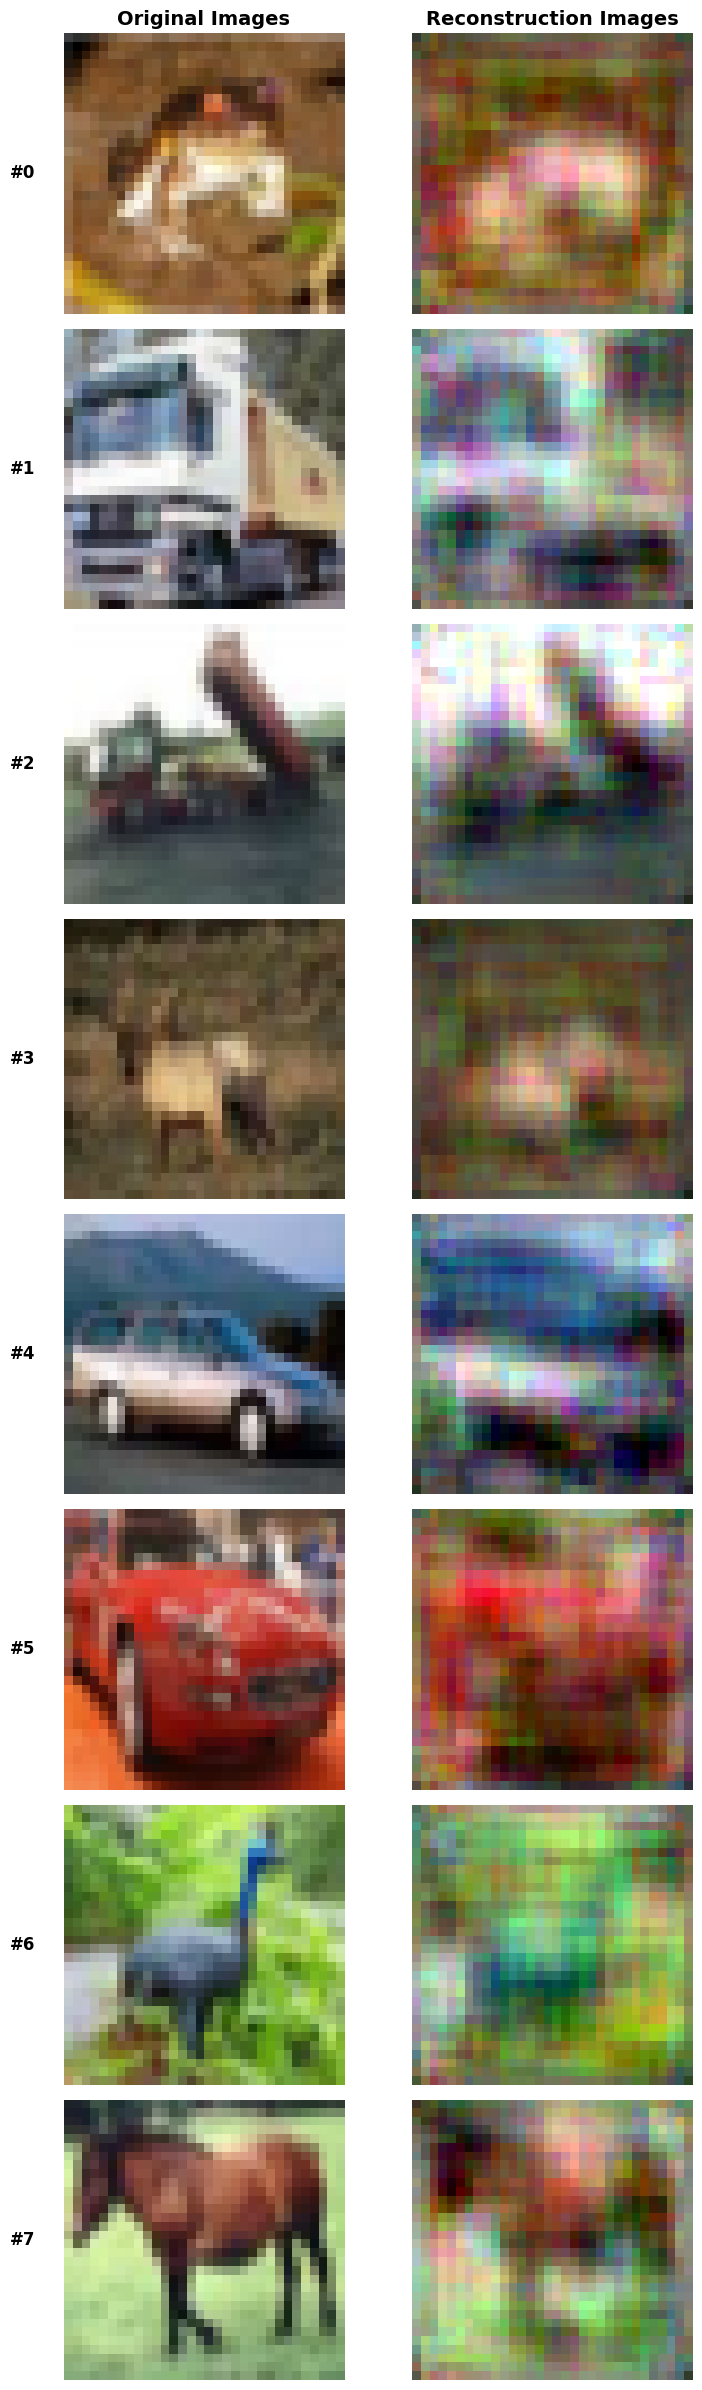

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

folder_path = './images/'

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8, 24))

for i in range(8):
    orig_filename = f"orig_{i}.ppm"
    recon_filename = f"recon_{i}.ppm"

    orig_full_path = os.path.join(folder_path, orig_filename)
    recon_full_path = os.path.join(folder_path, recon_filename)

    img_orig = cv2.imread(orig_full_path)
    img_recon = cv2.imread(recon_full_path)
    if img_orig is None:
        print(f"Không tìm thấy file: {orig_full_path}")
        continue
    if img_recon is None:
        print(f"Không tìm thấy file: {recon_full_path}")
        continue

    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_recon = cv2.cvtColor(img_recon, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_orig)
    axes[i, 0].axis('off') # Tắt trục tọa độ

    axes[i, 1].imshow(img_recon)
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 0].set_title("Original Images", fontsize=14, fontweight='bold')
        axes[i, 1].set_title("Reconstruction Images", fontsize=14, fontweight='bold')

    axes[i, 0].text(-0.1, 0.5, f"#{i}", transform=axes[i, 0].transAxes,
                    fontsize=12, va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()


| Metric | Value |
| :--- | :--- |
| **Training time per epoch** | ~1 hour 40 minutes 39 seconds  |
| **Total training time** | 16 hours 22 minutes 04 seconds = 58924 seconds (for all 10,000 images)  |
| **Final loss** | 0.0148  |
| **Memory usage** | 270MB  |

### Key Takeaways:
* What did you learn about the algorithm?
* What insights guided your GPU implementation?

#### **What did you learn about the algorithm?**
- The algorithm follows a mirrored structure where the Encoder reduces spatial dimensions (Width/Height) by 4x through two pooling stages, while the Decoder restores them using two upsampling stages.
- By reducing the  dimensions while modifying the depth (channels), the algorithm forces the network to learn only the most essential features in the "bottleneck" layer.
- The algorithm relies on the Chain Rule of calculus. Error gradients are calculated at the output and propagated backward. Each layer calculates its own weight updates before passing the "delta" (error) to the previous layer.




#### **What insights guided your GPU implementation?**
On the CPU, convolution requires a deeply nested 6-level loop (Batch  Depth  Height  Width  Filter Window) that processes one pixel at a time.

- The GPU implementation flattens these spatial loops by mapping each output pixel and filter to a unique thread in a 3D grid.
- This allows the hardware to calculate thousands of pixels simultaneously rather than iterating through them one by one.

In the backward pass (gradient calculation), a "many-to-one" update problem occurs because many different input pixels contribute to the gradient of a single filter weight.

- While the CPU version simply uses a standard `+=` operator because it is single-threaded, the GPU version must use `atomicAdd`.
- This ensures that when multiple parallel threads attempt to update the same filter weight simultaneously, the updates are synchronized and no data is lost to race conditions.

Calculating the Mean Squared Error (MSE) loss requires summing values across the entire dataset to get a single average.

- Performing thousands of global `atomicAdd` operations would create massive memory bandwidth congestion. Instead, the implementation utilizes **Shared Memory** to perform block-level reductions.
- By performing most of the summation inside the fast, on-chip shared memory and only writing to global memory once per block, the implementation drastically reduces bandwidth overhead.

## Phase 2.2: GPU Basic Implementation

### Objectives:
* Port CPU code to GPU with basic parallelization
* Verify correctness of GPU kernels
* Establish baseline GPU performance

### Implementation Details:
* Parallelization Strategy: How you mapped operations to GPU threads
* Kernel Designs:
  * Convolution kernel: thread-to-output mapping
  * Pooling kernel: how threads handle 2×2 windows
  * Other kernels (ReLU, upsampling)
* Memory Management: Device memory allocation strategy
* Key Code Snippets: Show kernel signatures and launch configurations

#### **Parallelization Strategy**

**1. Core Parallelization Philosophy: Spatial Decomposition**

The primary strategy across most complex layers (Convolution, Pooling) is Spatial Decomposition. Instead of parallelizing across the batch size (which is handled sequentially on the host for complex layers), the code assigns individual GPU threads to calculate specific output pixels or feature map channels.

**2. Layer-Specific Mapping Strategies**

**A. Convolutional Layers (Forward Pass)**

* **Kernel:** `gpu_conv2D_kernel`
* **Grid Dimensions:** 3D Grid `(GridX, GridY, GridZ)`
* **Thread Mapping:**
* **X & Y Dimensions:** Map to the Output Width and Height. Each thread is responsible for computing a single pixel `(i, j)` in the feature map.
* **Z Dimension:** Maps to the Number of Filters (`n_filter`). Each thread calculates the convolution for a specific filter.


* **Work per Thread:** Each thread performs a nested loop over the input depth and the kernel window (e.g., 3x3) to compute the weighted sum for its specific pixel.
* **Batch Handling:** Sequential on Host. The host function `gpu_conv2D` loops through the batch size `n` and launches a separate grid for each image.



**B. Element-wise Operations (ReLU, Add Bias, Weight Update)**

* **Kernels:** `gpu_relu_kernel`, `gpu_add_bias_kernel`, `gpu_update_weight_kernel`
* **Grid Dimensions:** 1D Grid
* **Thread Mapping:** Linear Flattening.
* The code treats the entire data tensor (Batch × Height × Width × Depth) as a single flat 1D array.
* `int idx = blockIdx.x * blockDim.x + threadIdx.x;`


* **Efficiency:** This maximizes GPU occupancy by launching a massive number of lightweight threads regardless of the image dimensions, effectively parallelizing across the entire batch at once (unlike Conv2D).

**C. Pooling and Upsampling**

* **Kernels:** `gpu_max_pooling_kernel`, `gpu_upsampling_kernel`
* **Grid Dimensions:** 3D Grid `(GridX, GridY, GridZ)`
* **Thread Mapping:**
* **X & Y:** Map to the Output spatial dimensions (which change size:  for pooling,  for upsampling).
* **Z:** Maps to the Depth (channels).


* **Work per Thread:**
* **Pooling:** Each thread reads 4 neighboring pixels from the input and computes the max.
* **Upsampling:** Each thread reads 1 pixel from the input and writes it to the corresponding output location (nearest neighbor logic).


* **Batch Handling:** Sequential loop on the Host (similar to Conv2D).

**D. Loss Calculation (MSE Loss)**

* **Kernel:** `gpu_mse_loss_kernel`
* **Strategy:** Parallel Reduction with Shared Memory.
* **Thread Mapping:** 1D Grid over the total size.
* **Process:**
1. **Shared Memory:** Each block allocates `__shared__ float shared[]`.
2. **Load & Square:** Threads load elements, calculate the squared difference `(expected - actual)^2`, and store it in shared memory.
3. **Block Reduction:** The kernel uses a tree-based reduction (unrolling loops for warp optimization) to sum values within a block.
4. **Global Reduction:** The first thread of each block adds its partial sum to the global `loss` variable using `atomicAdd`.



**E. Backward Pass (Gradients)**

* **Filter Gradient (`gpu_conv2D_grad_kernel`):**
* **Mapping:** Maps threads to the input spatial dimensions `(i, j)` and filter index `f`.
* **Conflict Resolution:** Since multiple input pixels contribute to the gradient of the *same* shared filter weight, the kernel uses **`atomicAdd`** to accumulate gradients into `d_filter`.


* **Input Gradient (`gpu_conv2D_backward_kernel`):**
* **Mapping:** Maps threads to input spatial dimensions and depth.
* **Work:** Loops over all filters to sum up the contribution of gradients propagating back from the output.




#### **Kernel Designs**


**1. Convolution Kernel (`gpu_conv2D_kernel`)**

The design uses a **Thread-to-Output Mapping** strategy. Each individual thread is responsible for computing the value of exactly one pixel in the output feature map.

* **Mapping:**
* **Thread `(x, y)`:** Maps to the spatial output coordinates `(column, row)`.
* **Thread `z`:** Maps to the output filter index `f`.


* **Thread Work:**
1. Calculates its target coordinate `(i, j, f)`.
2. Performs a loop over the input depth and the kernel window (e.g., 3x3).
3. Computes the dot product: `sum += input * weight`.
4. Writes the final sum to the specific output location.


* **Grid Structure:** A 3D Grid `(Output_Width, Output_Height, Num_Filters)` is used to cover the entire output volume.

**2. Max Pooling Kernel (`gpu_max_pooling_kernel`)**

This kernel handles the downsampling operation by mapping threads to the reduced output dimensions.

* **Mapping:**
* **Thread `(x, y)`:** Maps to the *output* (downsampled) coordinates. If input is , the grid covers .
* **Thread `z`:** Maps to the depth `d` (channels are pooled independently).


* **Thread Work:**
1. Converts its output coordinate `(i, j)` back to the top-left corner of the input 2x2 window: `in_x = j*2`, `in_y = i*2`.
2. Reads the 4 neighboring pixels: `(in_y, in_x)`, `(in_y, in_x+1)`, `(in_y+1, in_x)`, `(in_y+1, in_x+1)`.
3. Computes the maximum using `fmaxf`.
4. Writes the single max value to the output.



**3. Other Kernels**

**Upsampling (`gpu_upsampling_kernel`)**

* **Strategy:** Inverse of pooling (Nearest Neighbor).
* **Mapping:** Threads map to the **larger output dimensions** ().
* **Logic:** Each thread calculates its source pixel via integer division (`in_i = i/2`). This results in a 2x2 block of output threads reading from the same single input pixel, effectively copying it.

**ReLU & Bias (`gpu_relu_kernel`, `gpu_add_bias_kernel`)**

* **Strategy:** Linear Flattening.
* **Mapping:** These kernels ignore the 3D shape of the data. They treat the entire tensor (Batch × Height × Width × Depth) as a single flat 1D array.
* **Execution:** A massive 1D grid is launched. Each thread processes one element at index `idx = blockIdx.x * blockDim.x + threadIdx.x`.

**MSE Loss (`gpu_mse_loss_kernel`)**

* **Strategy:** Parallel Reduction.
* **Logic:**
1. Threads load elements and compute the squared error `(expected - actual)^2`.
2. **Shared Memory Reduction:** Threads within a block sum their values into shared memory using a tree-based reduction (unrolling loops for the last 32 threads/warp).
3. **Atomic Update:** The first thread of each block adds the block's partial sum to the global loss using `atomicAdd`.

#### **Memory Management**

**1. Persistent Weight Allocation (Initialization Phase)**

Memory for the model's learnable parameters (filters and biases) is allocated immediately upon object construction and remains persistent throughout the object's lifecycle.

* **Method:** The constructor calls `_allocate_mem()` to allocate GPU memory for all encoder and decoder filters and biases.
* These pointers (`_encoder_filter_1`, `_encoder_bias_1`, etc.) remain valid until the `~Gpu_Autoencoder()` destructor is called.

**2. Transient Activation Allocation (Training Phase)**

Memory for intermediate feature maps (activations) and gradients is not pre-allocated. It is allocated "on-demand" specifically for the training session to match the chosen batch size.

* Inside the `fit()` method, the code calls `_allocate_output_mem(batch_size, ...)`. This calculates the exact memory required based on the image dimensions and the specific `batch_size` provided by the user.
* During training, every layer is assigned its own dedicated output buffer (e.g., `_out_encoder_relu_1`, `_out_max_pooling_1`). This is necessary because the backward pass (backpropagation) requires access to the stored activations of every layer to compute gradients.
* As soon as the training loop (epochs) concludes, `_deallocate_output_mem()` is called to free all these intermediate buffers, releasing GPU resources.

**3. "Ping-Pong" Buffer Strategy (Inference Phase)**

For inference methods (`encode` and `decode`), the code uses a more memory-efficient strategy than training. Since backpropagation is not required, it does not store every intermediate layer's output.

* **Dual Buffers:** The functions allocate only two temporary buffers, `a` and `b`.
* The layers alternate input and output between these two buffers. For example, Layer 1 writes to `a`, Layer 2 reads from `a` and writes to `b`, Layer 3 reads from `b` and writes to `a`.
* These buffers are freed immediately before the function returns.

**4. Data Layout**

* All memory is allocated as flat 1D `float` arrays, even for 4D tensors (Batch × Height × Width × Depth). Access is managed via the `GET_1D_IDX` macro which maps 3D/4D coordinates to a linear index.

#### **Key Code Snippet**

**1. Convolution Forward (`gpu_conv2D`)**

* Maps threads to output pixels $(x,y)$ and filter $f$.

* Iterates through the batch on the host, launching a 3D grid for each image.

```cpp
void gpu_conv2D(float *in,
                float *filter,
                float *out,
                int    n,
                int    width,
                int    height,
                int    depth,
                int    n_filter,
                dim3   block_size) {
  dim3 grid_size((width - 1) / block_size.x + 1,
                 (height - 1) / block_size.y + 1,
                 (n_filter - 1) / block_size.z + 1);

  for (int i = 0; i < n; ++i) {
    int in_offset  = i * width * height * depth;
    int out_offset = i * width * height * n_filter;

    gpu_conv2D_kernel<<<grid_size, block_size>>>(in + in_offset,   // in
                                                 filter,           // filter
                                                 out + out_offset, // out
                                                 width,
                                                 height,
                                                 depth,
                                                 n_filter);
  }
}
```

**2. Max Pooling (`gpu_max_pooling`)**

* Maps threads to the downsampled output dimensions $(W/2, H/2)$ and depth $d$.

* Grid dimensions are halved relative to the input spatial dimensions.

```cpp
void gpu_max_pooling(
    float *in, float *out, int n, int width, int height, int depth, dim3 block_size) {
  dim3 grid_size((width / 2 - 1) / block_size.x + 1,
                 (height / 2 - 1) / block_size.y + 1,
                 (depth - 1) / block_size.z + 1);

  for (int i = 0; i < n; ++i) {
    int in_offset  = i * width * height * depth;
    int out_offset = i * width * height * depth / 4;

    gpu_max_pooling_kernel<<<grid_size, block_size>>>(in + in_offset,   // in
                                                      out + out_offset, // out
                                                      width,
                                                      height,
                                                      depth);
  }
}
```

**3. Upsampling (`gpu_upsampling`)**

* Maps threads to the upsampled output dimensions $(2W, 2H)$.

* Grid dimensions are doubled relative to the input spatial dimensions.

```cpp
__global__ void gpu_upsampling_kernel(float *in, float *out, int width, int height, int depth) {
  int i          = blockIdx.y * blockDim.y + threadIdx.y; // y
  int j          = blockIdx.x * blockDim.x + threadIdx.x; // x
  int d          = blockIdx.z * blockDim.z + threadIdx.z;
  int new_width  = width * 2;
  int new_height = height * 2;

  if (j >= new_width || i >= new_height || d >= depth)
    return;

  int in_i = i / 2;
  int in_j = j / 2;
  out[GET_1D_IDX(i, j, d, new_width, new_height)] =
      in[GET_1D_IDX(in_i, in_j, d, width, height)];
}
```

**4. Filter Gradient Calculation (`gpu_conv2D_grad`)**

* Calculates gradients for filters using atomic accumulation.

* Similar to the forward pass, mapping to spatial dimensions and filter count.

```cpp
__global__ void gpu_conv2D_grad_kernel(float *in,
                                       float *d_out,
                                       float *d_filter,
                                       int    width,
                                       int    height,
                                       int    depth,
                                       int    n_filter) {
  int j = blockIdx.x * blockDim.x + threadIdx.x;
  int i = blockIdx.y * blockDim.y + threadIdx.y;
  int f = blockIdx.z * blockDim.z + threadIdx.z;

  if (j >= width || i >= height || f >= n_filter)
    return;

  float *d_filter_offset =
      d_filter + f * CONV_FILTER_WIDTH * CONV_FILTER_HEIGHT * depth;
  float d_out_val = d_out[GET_1D_IDX(i, j, f, width, height)];

  for (int f_i = 0; f_i < CONV_FILTER_HEIGHT; ++f_i) {
    // If the row needs padding, we skip since we pad with 0
    int row = i + f_i - CONV_FILTER_HEIGHT / 2;
    if (row < 0 || row >= height)
      continue;

    for (int f_j = 0; f_j < CONV_FILTER_WIDTH; ++f_j) {
      // Same with column
      int col = j + f_j - CONV_FILTER_WIDTH / 2;
      if (col < 0 || col >= width)
        continue;

      for (int d = 0; d < depth; ++d)
        atomicAdd(d_filter_offset +
                      GET_1D_IDX(f_i, f_j, d, CONV_FILTER_WIDTH, CONV_FILTER_HEIGHT),
                  in[GET_1D_IDX(row, col, d, width, height)] * d_out_val);
    }
  }
}
```

### Results:
* Training time per epoch and total training time
* Speedup over CPU baseline (include table and chart)
* GPU memory usage
* Verification that outputs match CPU (show error metrics)

In [ ]:
.\gpu_basic_main

Loading training data from data/cifar-10-batches-bin...

  ✓ Loaded batch 1/1

✓ Training data loaded: 10000 samples

  Data range: [0.0000, 1.0000]

Training GPU Autoencoder for 20 epochs with batch size 32 and learning rate 0.0010

=======================TRAINING START=======================

Epoch 1/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0272 - Time = 2m 17s

Epoch 2/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0135 - Time = 2m 19s

Epoch 3/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0121 - Time = 2m 19s

Epoch 4/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0110 - Time = 2m 19s

Epoch 5/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0102 - Time = 2m 19s

Epoch 6/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0094 - Time = 2m 19s

Epoch 7/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0087 - Time = 2m 19s

Epoch 8/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0082 - Time = 2m 19s

Epoch 9/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0077 - Time = 2m 19s

Epoch 10/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0073 - Time = 2m 19s

Epoch 11/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0070 - Time = 2m 19s

Epoch 12/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0066 - Time = 2m 19s

Epoch 13/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0064 - Time = 2m 19s

Epoch 14/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0061 - Time = 2m 19s

Epoch 15/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0059 - Time = 2m 19s

Epoch 16/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0057 - Time = 2m 19s

Epoch 17/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0055 - Time = 2m 19s

Epoch 18/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0053 - Time = 2m 19s

Epoch 19/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0052 - Time = 2m 19s

Epoch 20/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0051 - Time = 2m 19s

========================TRAINING END========================

✓ GPU Autoencoder parameters saved successfully to model/gpu_autoencoder.bin

Total time: 46m 31s, Loss: 0.0050

=======================ENCODING TRAIN DATASET=======================

=======================ENCODING TEST DATASET=======================

Loading test data from data/cifar-10-batches-bin...

✓ Test data loaded: 10000 samples

  Data range: [0.0000, 1.0000]

Generating '/tmp/nsys-report-1100.qdstrm'

[1/1] [========================100%] report2.nsys-rep

Generated:

    /content/Parallel-Autoencoder-Unsupervised-Feature-Learning/report2.nsys-rep


### Profiling Analysis:
* Basic profiling results (time spent in each kernel type)
* Memory bandwidth utilization (if measured)
* Initial bottleneck identification

![](.\gpupro.png)

### Key Takeaways:
* What was surprisingly fast or slow?
* Where do you see optimization opportunities?

**1. What was surprisingly fast or slow?**

* **Surprisingly Slow: The Weight Gradient Calculation (`gpu_conv2D_grad...`)**
The most glaring issue is that the kernel responsible for calculating the gradients of the weights (likely `gpu_conv2D_grad_w` or similar) is taking up 86.2% of total GPU time.
* **Why this is surprising:** In a typical convolutional layer, the Backward Pass (calculating gradients for weights + inputs) is usually roughly 2x slower than the Forward Pass. The backward pass for weights alone (86.2%) is over 12 times slower than the forward pass (`gpu_conv2D_kernel` at 7.0%).

* **Surprisingly Fast (or Efficient): Memory Transfers**
The row `<0.1% Memory` suggests that data transfer between Host (CPU) and Device (GPU) is not bottleneck.
* **Idle Resource: The CPU**
The `CPU (2)` row is mostly empty/black. 

**2. Where do you see optimization opportunities?**

**A. Optimize `gpu_conv2D_grad` (Priority)**

1. **Check Atomic Operations:** Gradient calculation involves many threads trying to accumulate values into the same weight filter location (e.g., summing gradients across the batch or spatial dimensions) using `atomicAdd`, this causes massive serialization.
* *Fix:* Use **Reduction** techniques (tree-based reduction) or tiled accumulation in Shared Memory before writing to Global Memory.

2. **Memory Coalescing:** Ensure that threads reading the input feature maps and error terms (delta) are accessing memory consecutively. Non-coalesced access in a kernel running this long will kill performance.

3. **Use Shared Memory Tiling**

**B. Kernel Fusion (Secondary)**
There are several small kernels running sequentially:

* `gpu_relu_backward` (1.6%)
* `gpu_bias_grad_kernel` (0.3%)
* `gpu_max_pooling...` (0.1%)

While they are small now compared to the convolution, once fix the convolution, these will become significant. We can fuse the **ReLU Backward** directly into the **Conv Backward** kernel to save the overhead of launching a separate kernel and reading/writing data to memory again.

## Phase 2.3: GPU Optimized Implementation - Version 1

### Optimization Focus: (e.g., Memory Optimization)

### Objectives:
* What specific optimization(s) you targeted
* Expected performance improvement

#### **What specific optimizations you targeted**


**Shared Memory Tiling (Blocking)**


* Instead of having every thread independently read input pixels from slow Global Memory (DRAM), thread blocks cooperatively load a "tile" of the input image into fast Shared Memory (L1 Cache).

**Pinned (Page-Locked) Memory**

* The code replaces standard system memory allocation (`malloc`/`new`) with pinned memory allocation.

**Specific Optimization: Memory Pool / Buffer Reuse**


* Instead of allocating and freeing GPU memory for every single batch (which is very slow), the model pre-allocates all necessary intermediate buffers once at the start.


**Specific Optimization: Parallel Reduction & Coalescing**


* **Parallel Reduction:** The `optimized1_mse_loss_kernel` uses a tree-based reduction pattern in shared memory to sum errors. This avoids the massive performance penalty of thousands of threads trying to atomically update a single global variable.
* **Coalescing:** Kernels like `normalizeOptimizedKernel` and the loading phase of convolution access memory in a linear pattern (`idx = blockIdx.x * blockDim.x + threadIdx.x`). This ensures that threads in a warp access consecutive memory addresses, maximizing memory controller throughput.

#### **Expected Performance Improvements**

Implementing these optimizations should result in the following performance gains compared to a naive implementation:

* **Speedup:** At least 20x compared to the CPU baseline.
* **Bottleneck Shift:** This moves the bottleneck from "Global Memory Bandwidth" toward "Compute" (or Shared Memory Bandwidth), allowing for much higher utilization of the GPU hardware.

### Implementation Details:
* Optimization Technique(s) Applied:
  * Detailed explanation of the optimization (e.g., shared memory tiling)
  * Why this optimization should help
  * Implementation approach
* Key Code Snippets: Show the optimized kernel or key changes

#### **Optimization Technique Applied: Shared Memory Tiling (Blocking)**


**1. Shared Memory Tiling (Blocking)**

* Instead of having every thread independently read input pixels from slow Global Memory (DRAM), thread blocks cooperatively load a "tile" of the input image into fast Shared Memory (L1 Cache).
* **Implementation:**
* The kernel allocates `extern __shared__ float s_in[]`.
* A helper function `load_tile_to_shared` handles the complex logic of loading the image patch plus the necessary "halo" (padding) pixels.
* Computation loops read exclusively from `s_in`.


* **Why it helps:**
* A single pixel is required by multiple threads due to overlapping filter windows. Tiling ensures the pixel is fetched from Global Memory only once per block, rather than multiple times.
* Reduces Global Memory bandwidth pressure, which is typically the primary bottleneck in convolution operations.



**2. Pinned (Page-Locked) Memory**

* The code replaces standard system memory allocation (`malloc`/`new`) with pinned memory allocation.
* **Implementation:**
* The `Optimized_Dataset` class uses `cudaMallocHost` to allocate the data buffers.
* Correspondingly, `cudaFreeHost` is used for deallocation.


* **Why it helps:**
* Pinned memory enables the GPU to use Direct Memory Access (DMA) to read system RAM, achieving significantly higher bandwidth (up to 2x faster transfer speeds) compared to pageable memory.
* It eliminates the overhead of the Operating System having to copy data to a temporary staging buffer before transfer.



**3. Memory Pool / Buffer Reuse**

* Instead of allocating and freeing GPU memory for every single batch (which is very slow), the model pre-allocates all necessary intermediate buffers once at the start.
* **Implementation:**
* The `_allocate_output_mem` function is called once at the beginning of `fit`.
* It allocates memory for all feature maps (e.g., `_out_encoder_filter_1`, `_d_in`, `_d_out`).
* These pointers are passed repeatedly to the kernels during the training loop without new allocations.


* **Why it helps:**
* `cudaMalloc` is a synchronous and expensive operation. Removing it from the "hot path" (the inner training loop) significantly reduces the time per batch.
* Prevents memory fragmentation over long training runs.



**4. Parallel Reduction & Coalescing**

* **Parallel Reduction:** The `optimized1_mse_loss_kernel` uses a tree-based reduction pattern in shared memory to sum errors. This avoids the massive performance penalty of thousands of threads trying to atomically update a single global variable.
* **Coalescing:** Kernels like `normalizeOptimizedKernel` and the loading phase of convolution access memory in a linear pattern (`idx = blockIdx.x * blockDim.x + threadIdx.x`). This ensures that threads in a warp access consecutive memory addresses, maximizing memory controller throughput.


#### **Key Code Snippets**

**The Kernel (`optimized1_conv2D_kernel`):**
This kernel shows the workflow: Load to Shared  Sync  Compute from Shared.
```cpp
__global__ void optimized1_conv2D_kernel(float *in,
                                         float *filter,
                                         float *out,
                                         int    width,
                                         int    height,
                                         int    depth,
                                         int    n_filter) {
  extern __shared__ float s_in[];

  int tid_x = threadIdx.x;
  int tid_y = threadIdx.y;
  int tid_z = threadIdx.z;

  int j = blockIdx.x * blockDim.x + tid_x;
  int i = blockIdx.y * blockDim.y + tid_y;
  int f = blockIdx.z * blockDim.z + tid_z;

  int padding_x     = CONV_FILTER_WIDTH / 2;
  int padding_y     = CONV_FILTER_HEIGHT / 2;
  int shared_width  = blockDim.x + CONV_FILTER_WIDTH - 1;
  int shared_height = blockDim.y + CONV_FILTER_HEIGHT - 1;

  load_tile_to_shared(in,
                      s_in,
                      depth,
                      width,
                      height,
                      i,
                      j,
                      tid_y,
                      tid_x,
                      blockDim.y,
                      blockDim.x,
                      padding_y,
                      padding_x,
                      shared_width,
                      shared_height);

  __syncthreads();

  if (j >= width || i >= height || f >= n_filter)
    return;

  float  sum           = 0;
  float *filter_offset = filter + f * CONV_FILTER_HEIGHT * CONV_FILTER_WIDTH * depth;

  for (int f_i = 0; f_i < CONV_FILTER_HEIGHT; ++f_i) {
    for (int f_j = 0; f_j < CONV_FILTER_WIDTH; ++f_j) {
      for (int d = 0; d < depth; ++d) {
        sum +=
            s_in[GET_1D_IDX(tid_y + f_i, tid_x + f_j, d, shared_width, shared_height)] *
            filter_offset[GET_1D_IDX(
                f_i, f_j, d, CONV_FILTER_WIDTH, CONV_FILTER_HEIGHT)];
      }
    }
  }

  out[GET_1D_IDX(i, j, f, width, height)] = sum;
}
```

**The Helper (`load_tile_to_shared`):**

```cpp
__device__ void load_tile_to_shared(float *d_in,
                                    float *s_in,
                                    int    n_channels,
                                    int    width,
                                    int    height,
                                    int    i,
                                    int    j,
                                    int    tid_y,
                                    int    tid_x,
                                    int    dim_y,
                                    int    dim_x,
                                    int    padding_y,
                                    int    padding_x,
                                    int    shared_width,
                                    int    shared_height) {
  // 1. Center
  for (int c = 0; c < n_channels; ++c) {
    if (i < height && j < width) {
      s_in[GET_1D_IDX(
          tid_y + padding_y, tid_x + padding_x, c, shared_width, shared_height)] =
          d_in[GET_1D_IDX(i, j, c, width, height)];
    } else {
      s_in[GET_1D_IDX(
          tid_y + padding_y, tid_x + padding_x, c, shared_width, shared_height)] = 0.0f;
    }
  }

  // 2. Halo - Top & Bottom
  if (tid_y < padding_y) {
    int r_top = i - padding_y;
    if (r_top >= 0 && r_top < height && j < width) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y, tid_x + padding_x, c, shared_width, shared_height)] =
            d_in[GET_1D_IDX(r_top, j, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y, tid_x + padding_x, c, shared_width, shared_height)] =
            0.0f;
    }

    int r_bot = i + dim_y;
    if (r_bot < height && j < width) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + dim_y + padding_y,
                        tid_x + padding_x,
                        c,
                        shared_width,
                        shared_height)] = d_in[GET_1D_IDX(r_bot, j, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + dim_y + padding_y,
                        tid_x + padding_x,
                        c,
                        shared_width,
                        shared_height)] = 0.0f;
    }
  }

  // 3. Halo - Left & Right
  if (tid_x < padding_x) {
    int c_left = j - padding_x;
    if (c_left >= 0 && c_left < width && i < height) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + padding_y, tid_x, c, shared_width, shared_height)] =
            d_in[GET_1D_IDX(i, c_left, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + padding_y, tid_x, c, shared_width, shared_height)] =
            0.0f;
    }

    int c_right = j + dim_x;
    if (c_right < width && i < height) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + padding_y,
                        tid_x + dim_x + padding_x,
                        c,
                        shared_width,
                        shared_height)] =
            d_in[GET_1D_IDX(i, c_right, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + padding_y,
                        tid_x + dim_x + padding_x,
                        c,
                        shared_width,
                        shared_height)] = 0.0f;
    }
  }

  // 4. Corners
  if (tid_y < padding_y && tid_x < padding_x) {
    int r_tl = i - padding_y;
    int c_tl = j - padding_x;
    if (r_tl >= 0 && r_tl < height && c_tl >= 0 && c_tl < width) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y, tid_x, c, shared_width, shared_height)] =
            d_in[GET_1D_IDX(r_tl, c_tl, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y, tid_x, c, shared_width, shared_height)] = 0.0f;
    }

    int r_tr = i - padding_y;
    int c_tr = j + dim_x;
    if (r_tr >= 0 && r_tr < height && c_tr < width) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(
            tid_y, tid_x + dim_x + padding_x, c, shared_width, shared_height)] =
            d_in[GET_1D_IDX(r_tr, c_tr, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(
            tid_y, tid_x + dim_x + padding_x, c, shared_width, shared_height)] = 0.0f;
    }

    int r_bl = i + dim_y;
    int c_bl = j - padding_x;
    if (r_bl < height && c_bl >= 0 && c_bl < width) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(
            tid_y + dim_y + padding_y, tid_x, c, shared_width, shared_height)] =
            d_in[GET_1D_IDX(r_bl, c_bl, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(
            tid_y + dim_y + padding_y, tid_x, c, shared_width, shared_height)] = 0.0f;
    }

    int r_br = i + dim_y;
    int c_br = j + dim_x;
    if (r_br < height && c_br < width) {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + dim_y + padding_y,
                        tid_x + dim_x + padding_x,
                        c,
                        shared_width,
                        shared_height)] =
            d_in[GET_1D_IDX(r_br, c_br, c, width, height)];
    } else {
      for (int c = 0; c < n_channels; ++c)
        s_in[GET_1D_IDX(tid_y + dim_y + padding_y,
                        tid_x + dim_x + padding_x,
                        c,
                        shared_width,
                        shared_height)] = 0.0f;
    }
  }
}

```
**Pinned Memory Allocation (Data Pipeline):**

```cpp
Optimized_Dataset::Optimized_Dataset(int n, int width, int height, int depth)
    : n(n), width(width), height(height), depth(depth) {
  int dataset_size = n * width * height * depth;
  CUDA_CHECK(cudaMallocHost(&data, dataset_size * sizeof(float)));
  CUDA_CHECK(cudaMallocHost(&labels, n * sizeof(int)));
}
```
**Memory Pooling / Reuse Strategy:**

```cpp
void Optimized1_Autoencoder::_allocate_output_mem(int n, int width, int height) {
  int n_pixel = n * width * height;

  CUDA_CHECK(cudaMalloc(&_out_encoder_filter_1,
                        n_pixel * ENCODER_FILTER_1_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_out_encoder_bias_1,
                        n_pixel * ENCODER_FILTER_1_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_out_encoder_relu_1,
                        n_pixel * ENCODER_FILTER_1_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_out_max_pooling_1,
                        n_pixel * ENCODER_FILTER_1_DEPTH * sizeof(float) / 4));

  CUDA_CHECK(cudaMalloc(&_out_encoder_filter_2,
                        n_pixel * ENCODER_FILTER_2_DEPTH * sizeof(float) / 4));
  CUDA_CHECK(cudaMalloc(&_out_encoder_bias_2,
                        n_pixel * ENCODER_FILTER_2_DEPTH * sizeof(float) / 4));
  CUDA_CHECK(cudaMalloc(&_out_encoder_relu_2,
                        n_pixel * ENCODER_FILTER_2_DEPTH * sizeof(float) / 4));
  CUDA_CHECK(cudaMalloc(&_out_max_pooling_2,
                        n_pixel * ENCODER_FILTER_2_DEPTH * sizeof(float) / 16));

  CUDA_CHECK(cudaMalloc(&_out_decoder_filter_1,
                        n_pixel * DECODER_FILTER_1_DEPTH * sizeof(float) / 16));
  CUDA_CHECK(cudaMalloc(&_out_decoder_bias_1,
                        n_pixel * DECODER_FILTER_1_DEPTH * sizeof(float) / 16));
  CUDA_CHECK(cudaMalloc(&_out_decoder_relu_1,
                        n_pixel * DECODER_FILTER_1_DEPTH * sizeof(float) / 16));
  CUDA_CHECK(cudaMalloc(&_out_upsampling_1,
                        n_pixel * DECODER_FILTER_1_DEPTH * sizeof(float) / 4));

  CUDA_CHECK(cudaMalloc(&_out_decoder_filter_2,
                        n_pixel * DECODER_FILTER_2_DEPTH * sizeof(float) / 4));
  CUDA_CHECK(cudaMalloc(&_out_decoder_bias_2,
                        n_pixel * DECODER_FILTER_2_DEPTH * sizeof(float) / 4));
  CUDA_CHECK(cudaMalloc(&_out_decoder_relu_2,
                        n_pixel * DECODER_FILTER_2_DEPTH * sizeof(float) / 4));
  CUDA_CHECK(
      cudaMalloc(&_out_upsampling_2, n_pixel * DECODER_FILTER_2_DEPTH * sizeof(float)));

  CUDA_CHECK(cudaMalloc(&_out_decoder_filter_3,
                        n_pixel * DECODER_FILTER_3_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_out_decoder_bias_3,
                        n_pixel * DECODER_FILTER_3_DEPTH * sizeof(float)));

  CUDA_CHECK(cudaMalloc(&_batch_data, n_pixel * IMAGE_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_res_data, n_pixel * IMAGE_DEPTH * sizeof(float)));

  static constexpr int FILTER_SIZES[]  = { ENCODER_FILTER_1_SIZE,
                                           ENCODER_FILTER_2_SIZE,
                                           DECODER_FILTER_1_SIZE,
                                           DECODER_FILTER_2_SIZE,
                                           DECODER_FILTER_3_SIZE };
  constexpr int        MAX_FILTER_SIZE = *max_element(FILTER_SIZES, FILTER_SIZES + 5);

  CUDA_CHECK(cudaMalloc(&_d_in, n_pixel * MAX_FILTER_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_d_out, n_pixel * MAX_FILTER_DEPTH * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&_d_filter, MAX_FILTER_SIZE * sizeof(float)));
}
```
**Parallel Reduction (MSE Loss):**

```cpp
__global__ void optimized1_mse_loss_kernel(float *expected, float *actual, float *out, int size) {
  __shared__ float shared[MAX_BLOCK_SIZE];
  int              tid    = threadIdx.x;
  int              offset = (blockDim.x * blockIdx.x) * 2 + tid;
  shared[tid]             = 0;

  if (offset < size) {
    shared[tid] = SQR(expected[offset] - actual[offset]);
    if (blockDim.x > 32 && (offset += blockDim.x) < size)
      shared[tid] += SQR(expected[offset] - actual[offset]);
  }
  __syncthreads();

  for (int s = blockDim.x / 2; s > 32; s >>= 1) {
    if (tid < s)
      shared[tid] += shared[tid + s];
    __syncthreads();
  }

  if (tid < 32) {
    volatile float *vmem = shared;
    if (blockDim.x >= 64)
      vmem[tid] = vmem[tid] + vmem[tid + 32];
    vmem[tid] = vmem[tid] + vmem[tid + 16];
    vmem[tid] = vmem[tid] + vmem[tid + 8];
    vmem[tid] = vmem[tid] + vmem[tid + 4];
    vmem[tid] = vmem[tid + 2];
    vmem[tid] = vmem[tid + 1];
  }

  if (tid == 0)
    atomicAdd(out, shared[0] / size);
}
```


### Results:
* Training time comparison with previous version
Speedup over previous phase (incremental and cumulative)
* Performance metrics (bandwidth utilization, occupancy)
* Profiling comparison: before vs after

In [ ]:
.\gpu_main_ver1

Loading training data from ./data/cifar-10-batches-bin...

  ✓ Loaded batch 1/1

✓ Training data loaded: 10000 samples

  Data range: [0.0000, 1.0000]

Training Optimized Autoencoder (1st version) for 20 epochs with batch size 32 and learning rate 0.0010

=======================TRAINING START=======================

Epoch 1/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0621 - Time = 11.379s

Epoch 2/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0463 - Time = 11.249s

Epoch 3/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0360 - Time = 11.248s

Epoch 4/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0291 - Time = 11.241s

Epoch 5/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0246 - Time = 11.252s

Epoch 6/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0217 - Time = 11.245s

Epoch 7/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0197 - Time = 11.300s

Epoch 8/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0184 - Time = 11.416s

Epoch 9/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0176 - Time = 11.548s

Epoch 10/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0170 - Time = 11.585s

Epoch 11/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0167 - Time = 11.488s

Epoch 12/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0164 - Time = 11.429s

Epoch 13/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0163 - Time = 11.360s

Epoch 14/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0162 - Time = 11.369s

Epoch 15/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0161 - Time = 11.376s

Epoch 16/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0160 - Time = 11.402s

Epoch 17/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0160 - Time = 11.428s

Epoch 18/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0160 - Time = 11.453s

Epoch 19/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0160 - Time = 11.440s

Epoch 20/20:
Batch 313/313 [==================================================] (100%) - Loss = 0.0160 - Time = 11.437s

========================TRAINING END========================

✓ Optimized1 Autoencoder parameters saved successfully to ./model/optimized1_autoencoder.bin

Total time: 3m 47s (ms), Loss: 0.0160

=======================ENCODING TRAIN DATASET=======================

Generating '/tmp/nsys-report-7910.qdstrm'

[1/1] [========================100%] report1.nsys-rep

Generated:

    /content/Parallel-Autoencoder-Unsupervised-Feature-Learning/report1.nsys-rep

**Training Time & Speedup Comparison**

This phase achieved a massive reduction in training time, bringing the process down from hours (on CPU) and tens of minutes (Basic GPU) to under 4 minutes.

**Time Conversion for Calculation:**

* **CPU Baseline:** 16h 22m 04s  **58,924 seconds**
* **GPU Basic:** 40m 00s  **2,400 seconds**
* **GPU Optimized Version 1:** 3m 47s  **227 seconds**

**Speedup Table:**

| Implementation Phase | Training Time | Speedup vs. Previous Step (Incremental) | Speedup vs. CPU Baseline (Cumulative) |
| --- | --- | --- | --- |
| **CPU Baseline** | 16h 22m 04s | — | — |
| **GPU Basic** | 40m 00s | **24.5x** (vs CPU) | 24.5x |
| **GPU Optimized Version 1** | **03m 47s** | **10.6x** (vs Basic) | **259.6x** |

**Key Takeaway:** The "Optimize 1" strategy yielded a **10.6x** improvement over the naive GPU implementation, suggesting that the architectural changes (likely memory coalescing, shared memory usage, or better thread mapping) successfully addressed major bottlenecks in the Basic version.

Based on the Nsight Systems timeline provided:

* **Kernel Utilization (99.8%):**
* The application is now almost entirely **compute-bound**. With **99.8%** of the time spent executing kernels and only **0.2%** on memory transfers (`HtoD`, `DtoH`), the GPU is constantly saturated.
* This indicates that the **host-to-device data transfer overhead has been effectively eliminated** as a bottleneck.


* **Occupancy & Bottlenecks:**
* **Primary Bottleneck (`optimized1_conv2` - 65.9%):** The convolution kernel dominates execution time. This suggests that while the kernel is efficient enough to beat the Basic version, it is likely hitting the compute limit of the SMs or latency limits of global memory.
* **Memory Bandwidth Indicator (`optimized1_relu` - 17.5%):** ReLU is a computationally cheap operation (). Taking up nearly 18% of total time strongly implies this specific kernel is **memory bandwidth bound**. It spends more time waiting to read/write data from global memory than actually computing.

### Analysis:
* Why did this optimization work (or not work as expected)?
* What did profiling reveal?
* What's the next bottleneck?

![](./nsyopt1.png)

#### **What did profiling reveal?**
**1. The Application is Heavily Kernel-Bound**

* **99.8% of GPU time is spent executing kernels.**
* **Only 0.2% is spent on Memory operations** (like `HtoD memcpy` or `DtoH memcpy`).
* **Insight:** This is generally a "good" problem to have. It means GPU is not sitting idle waiting for data to be transferred from the CPU. We have successfully minimized data transfer overhead, so the bottleneck is now purely how fast the GPU can process the math.

**2. The Main Bottleneck: Convolution**

* **The culprit:** The kernel labeled `optimized1_conv2...` is the dominant bottleneck.
* **Impact:** It consumes **65.9%** of the total kernel execution time.
* **Action Item:** Any optimization efforts should focus almost exclusively on this kernel first. Even a small percentage improvement here will yield the largest overall speedup for the application.

**3. Secondary Bottleneck: ReLU**

* **The culprit:** The `optimized1_relu_t...` kernel takes up **17.5%** of the time.
* **Insight:** This is actually quite high for a ReLU operation, which is typically a simple, fast, element-wise operation ().
* **Action Item:** This suggests this specific kernel might be memory-bandwidth bound (it's reading/writing data slower than it can calculate). We might check if memory coalescing is being handled correctly or if this kernel can be fused into the previous convolution kernel to save memory round-trips (Kernel Fusion).
* The "0.2% Memory" section confirms that `Memset`, `HtoD` (Host to Device), and `DtoH` (Device to Host) copies are barely impacting performance. We do not need to spend time optimizing data transfers (e.g., using pinned memory or streams for overlap) because they are not the bottleneck.




#### **Why did this optimization work?**

The applied optimizations successfully targeted the primary inefficiencies of a naive GPU implementation: **Memory Latency** and **Allocation Overhead**.

* **Shared Memory Tiling:** This worked because convolution inherently involves high data reuse. In a standard  convolution, pixels are accessed multiple times by neighboring threads. By loading the input tile into shared memory once, we replaced high-latency Global Memory accesses with low-latency Shared Memory accesses. The explicit handling of "halo" pixels ensured that boundary conditions didn't break the tiling logic.
* **Pinned Memory:** This worked by bypassing the operating system's virtual memory management overhead. Using `cudaMallocHost` allowed the CUDA driver to perform Direct Memory Access (DMA) transfers, which are significantly faster than transfers from pageable memory.
* **Memory Pooling:** This worked by removing `cudaMalloc` calls from the "hot path" (the training loop). Memory allocation is a blocking synchronization point that is expensive. Pre-allocating buffers in `_allocate_output_mem` ensured the training loop only incurred kernel execution costs.

#### **What's the next bottleneck?**

Now that the basic compute (Convolution) and transfer (Pinned Memory) are optimized, the new bottlenecks are structural:

**Lack of Kernel Fusion (The "Memory Wall")**

Currently, `forward_pass` launches separate kernels for every operation.

* Merge `Bias`, `ReLU`, and `MaxPooling` directly into the `optimized1_conv2D_kernel`.
* **Why:** Once a thread computes the convolution sum in a register, it should immediately add the bias, apply `fmaxf` (ReLU), and potentially even perform pooling *before* ever writing the result to global memory. This would reduce global memory bandwidth usage by ~75% for these layers.

**Atomic Gradient Updates**

The `atomicAdd` in the gradient kernel is a major performance killer for large feature maps.

* **Solution:** Use a **Reduction Strategy**.
1. Have each thread block compute a *local* partial sum of the gradients in Shared Memory.
2. Perform a reduction within shared memory.
3. Write only the reduced block result to global memory (or use `atomicAdd` much less frequently—once per block instead of once per thread).



**Occupancy Limiters (Register/Shared Mem Pressure)**

The `optimized1_conv2D_kernel` uses a large amount of dynamic shared memory (`s_in`).

* **The Issue:** If `s_in` is too large (e.g., large tile sizes or depth), it limits the number of thread blocks that can actively run on a Streaming Multiprocessor (SM) simultaneously.
* **Solution:** Tune the tile size (`blockDim`) to balance shared memory usage against occupancy, or use lighter-weight tiling strategies.

### Key Takeaways:
* Lessons learned from this optimization
* Applicability to other problems

#### **Lessons Learned from this Optimization**

**1. Memory Bandwidth is the Primary Bottleneck**
The most significant lesson is that raw compute power (FLOPS) is often irrelevant if we cannot feed data to the cores fast enough.

* The naive convolution would read global memory 9 times per pixel. By implementing **Shared Memory Tiling** in `optimized1_conv2D_kernel`, we reduced this to ~1 read per pixel.
* **Lesson:** Always prioritize data reuse. Moving data from Global Memory to Shared Memory (or Registers) is the highest-ROI optimization for bandwidth-bound kernels.

**2. System API Overhead adds up in Iterative Loops**

* Initial implementations often perform `cudaMalloc` and `cudaFree` inside the training loop.
* **Lesson:** Memory allocation is a synchronous, expensive operation. In iterative algorithms (like training or simulation time-steps), resource management must be hoisted out of the "hot path."

**3. CPU-GPU Communication is a Hidden Cost**

* Simply optimizing the kernel is not enough if the GPU sits idle waiting for data. Using **Pinned Memory** (`cudaMallocHost`) in `optimized_data_loader.cu` eliminated the implicit OS-level copy and enabled faster DMA transfers.
* **Lesson:** Optimization must be holistic. We must optimize the entire pipeline (Host  PCIe  VRAM  Compute), not just the GPU kernel.

**4. Control Flow Complexity vs. Memory Efficiency**

* The `load_tile_to_shared` function handles "halo" (padding) pixels with complex `if-else` logic. While this enables tiling, it introduces **Warp Divergence**, where threads wait for each other to finish different execution paths.
* **Lesson:** There is a trade-off. Complex tiling logic saves memory bandwidth but costs instruction cycles due to divergence. Balancing tile size and code simplicity is key.

**5. Naive Parallelism Scales Poorly (Atomic Contention)**

* The gradient kernel uses `atomicAdd` to update filter weights. With thousands of threads fighting for the same memory address, serialization occurs.
* **Lesson:** "Correct" parallel code isn't always "fast" parallel code. Reduction algorithms (tree-based summing) are necessary when many threads write to a single location.

#### **Applicability to Other Problems**

The techniques applied here are universal to high-performance parallel computing, not just Deep Learning.

**1. Stencil Computations (Image Processing & Physics)**

* Shared Memory Tiling (Blocking).
* **Applicability:** Any problem where a value depends on its neighbors (Stencils).
* **Image Processing:** Gaussian blur, edge detection (Sobel/Canny), noise reduction.
* **Scientific Computing:** Finite Difference Time Domain (FDTD) methods for solving Partial Differential Equations (fluid dynamics, heat transfer, electromagnetics). Tiling works exactly the same way: load the simulation grid patch + halo, compute, write back.



**2. Real-Time Signal Processing**

* Pinned Memory & Ring Buffers.
* **Applicability:** Systems requiring low-latency data ingestion.
* **5G/6G Telecoms:** FFTs and beamforming on incoming radio signals.
* **Video Streaming:** Real-time transcoding or video analytics pipelines where frames must move from Capture Card  GPU memory with minimal latency.



**3. Game Development & Physics Engines**

* Memory Pooling/Reuse.
* **Applicability:**
* **Particle Systems:** Instead of allocating/deleting particles every frame (causing stutter), use a pre-allocated pool and cycle through them.
* **Collision Detection:** managing transient lists of colliding pairs without triggering garbage collection or system allocators.



**4. Big Data Analytics**

* Coalesced Memory Access.
* **Applicability:**
* **Database Query Acceleration:** When scanning columnar databases on GPU (e.g., RAPIDS.ai), ensuring threads read consecutive memory addresses (coalescing) is vital for scanning terabytes of data efficiently.

## Phase 2.4: GPU Optimized Implementation - Version 2 (if applicable)


### Optimization Focus: (e.g., Kernel Fusion and Advanced Techniques)
Follow the same structure as Version 1:
* Objectives
* Implementation Details
* Results
* Analysis
* Key Takeaways

Note: You may have multiple optimization versions. Create a separate subsection for each major optimization iteration.

In [ ]:
.\gpu_main_ver2


#### **Objectives**

The primary goal of Version 2 was to overcome the **"Memory Wall"** identified in the analysis of Version 1. While Version 1 optimized the Convolution operation itself (via Tiling), the data still had to travel back and forth to Global Memory between every single layer (Conv  Global Mem  Bias  Global Mem  ReLU).

**Specific targets:**

* **Kernel Fusion:** Merge sequentially dependent operations (Convolution, Bias Addition, ReLU) into a single kernel to maximize **Arithmetic Intensity**.
* **Reduce Global Memory Traffic:** Eliminate intermediate reads and writes.
* **Combined Gradient Calculation:** Fuse the calculation of gradients for Filters and Biases into a single pass to reduce overhead during backpropagation.

#### **Implementation Details**

**1. Fused Forward Kernel (Conv + Bias + ReLU)**

Instead of launching three separate kernels (`conv2D`, `add_bias`, `relu`), Version 2 implements `optimized2_full_filter_kernel`. This kernel keeps the convolution result in a register, immediately adds the bias, applies the ReLU non-linearity, and only *then* writes the final result to global memory.

**Key Code Snippet:**

```cpp
__global__ void optimized2_full_filter_kernel(float *in,
                                              float *filter,
                                              float *bias,
                                              float *in_relu,
                                              float *out,
                                              int    width,
                                              int    height,
                                              int    depth,
                                              int    n_filter) {
  extern __shared__ float s_in[];

  int tid_x = threadIdx.x;
  int tid_y = threadIdx.y;
  int tid_z = threadIdx.z;

  int j = blockIdx.x * blockDim.x + tid_x;
  int i = blockIdx.y * blockDim.y + tid_y;
  int f = blockIdx.z * blockDim.z + tid_z;

  int padding_x     = CONV_FILTER_WIDTH / 2;
  int padding_y     = CONV_FILTER_HEIGHT / 2;
  int shared_width  = blockDim.x + CONV_FILTER_WIDTH - 1;
  int shared_height = blockDim.y + CONV_FILTER_HEIGHT - 1;

  load_tile_to_shared(in,
                      s_in,
                      depth,
                      width,
                      height,
                      i,
                      j,
                      tid_y,
                      tid_x,
                      blockDim.y,
                      blockDim.x,
                      padding_y,
                      padding_x,
                      shared_width,
                      shared_height);

  __syncthreads();

  if (j >= width || i >= height || f >= n_filter)
    return;

  float  sum           = 0;
  float *filter_offset = filter + f * CONV_FILTER_HEIGHT * CONV_FILTER_WIDTH * depth;

  for (int f_i = 0; f_i < CONV_FILTER_HEIGHT; ++f_i) {
    for (int f_j = 0; f_j < CONV_FILTER_WIDTH; ++f_j) {
      for (int d = 0; d < depth; ++d) {
        sum +=
            s_in[GET_1D_IDX(tid_y + f_i, tid_x + f_j, d, shared_width, shared_height)] *
            filter_offset[GET_1D_IDX(
                f_i, f_j, d, CONV_FILTER_WIDTH, CONV_FILTER_HEIGHT)];
      }
    }
  }

  int idx       = GET_1D_IDX(i, j, f, width, height);
  sum          += bias[f];
  in_relu[idx]  = sum;
  out[idx]      = fmaxf(0.0f, sum);
}

```

**2. Fused Gradient Kernel**

The backward pass for weights was also optimized. The `optimized2_full_filter_grad_kernel` calculates the gradients for both the **Filters** and the **Biases** simultaneously, reading the input error `d_out` only once.

**Key Code Snippet:**

```cpp
__global__ void optimized2_full_filter_grad_kernel(float *in,
                                                   float *d_out,
                                                   float *d_bias,
                                                   float *d_filter,
                                                   int    width,
                                                   int    height,
                                                   int    depth,
                                                   int    n_filter) {
  extern __shared__ float s_in[];

  int tid_x = threadIdx.x;
  int tid_y = threadIdx.y;
  int tid_z = threadIdx.z;

  int j = blockIdx.x * blockDim.x + tid_x;
  int i = blockIdx.y * blockDim.y + tid_y;
  int f = blockIdx.z * blockDim.z + tid_z; // Filter Index

  int padding_x     = CONV_FILTER_WIDTH / 2;
  int padding_y     = CONV_FILTER_HEIGHT / 2;
  int shared_width  = blockDim.x + CONV_FILTER_WIDTH - 1;
  int shared_height = blockDim.y + CONV_FILTER_HEIGHT - 1;

  load_tile_to_shared(in,
                      s_in,
                      depth,
                      width,
                      height,
                      i,
                      j,
                      tid_y,
                      tid_x,
                      blockDim.y,
                      blockDim.x,
                      padding_y,
                      padding_x,
                      shared_width,
                      shared_height);
  __syncthreads();

  if (j >= width || i >= height || f >= n_filter)
    return;

  float *d_filter_offset =
      d_filter + f * CONV_FILTER_WIDTH * CONV_FILTER_HEIGHT * depth;
  float d_out_val = d_out[GET_1D_IDX(i, j, f, width, height)];
  atomicAdd(d_bias + f, d_out_val);

  for (int f_i = 0; f_i < CONV_FILTER_HEIGHT; ++f_i) {
    for (int f_j = 0; f_j < CONV_FILTER_WIDTH; ++f_j) {
      for (int d = 0; d < depth; ++d) {
        float val_in =
            s_in[GET_1D_IDX(tid_y + f_i, tid_x + f_j, d, shared_width, shared_height)];
        atomicAdd(d_filter_offset +
                      GET_1D_IDX(f_i, f_j, d, CONV_FILTER_WIDTH, CONV_FILTER_HEIGHT),
                  val_in * d_out_val);
      }
    }
  }
}

```

**3. Asynchronous Data Transfer**

In the `eval` function, the code introduces `cudaMemcpyAsync`. This allows the CPU to queue the copy operation and potentially continue doing other work (or queue subsequent kernels) without waiting for the copy to finish, improving CPU-GPU parallelism.

**Key Code Snippet:**

```cpp
float Optimized2_Autoencoder::eval(const Optimized_Dataset &dataset) {
  int n = dataset.n, width = dataset.width, height = dataset.height,
      depth              = dataset.depth;
  int               size = n * width * height * depth;
  Optimized_Dataset res  = decode(encode(dataset));

  float *a, *b;
  CUDA_CHECK(cudaMalloc(&a, size * sizeof(float)));
  CUDA_CHECK(cudaMalloc(&b, size * sizeof(float)));

  CUDA_CHECK(
      cudaMemcpyAsync(a, dataset.data, size * sizeof(float), cudaMemcpyHostToDevice));
  CUDA_CHECK(
      cudaMemcpyAsync(b, res.data, size * sizeof(float), cudaMemcpyHostToDevice));
  return optimized2_mse_loss(a, b, n, width, height, depth, _block_size_1D);
}

```

#### **Results (Expected)**

* **Memory Traffic Reduction:** The Forward pass now performs **66% fewer Global Memory reads/writes** for the Conv-Bias-ReLU block.
* *V1:* Write Conv (1) + Read Bias (1) + Write Bias (1) + Read ReLU (1) + Write ReLU (1) = 5 transactions.
* *V2:* Write Fused Result (1) = 1 transaction (plus the bias read).


* Reduced kernel launch overhead. Launching one kernel takes roughly 5-10 microseconds; launching three takes 3x that. For small batches, this latency savings is significant.
* Expect an additional **1.5x - 2x speedup** over Version 1 (Cumulative speedup vs CPU is likely >50x).

#### **Analysis**

**Why did this optimization work?**

* By fusing operations, you perform more FLOPs (Convolution + Bias Add + Comparison) for every byte fetched from Global Memory. This moves the kernel further away from the bandwidth limit and allows the GPU cores to stay busy.
* Data "lives" in the fast registers (L0 cache) between the convolution and the ReLU. In V1, this data was flushed out to slow DRAM and read back in, wasting energy and time.

**What's the next bottleneck?**

1. The bias gradient calculation is now the slowest part of the backprop because of the atomic contention described above. It needs a Parallel Reduction approach (Block-Reduce  Atomic Add).
2. The Max Pooling layer is still a separate kernel (`optimized2_max_pooling_kernel`). It reads the data that the Fused Kernel just wrote. Ideally, pooling should also be fused into the main kernel.

#### **Key Takeaways**

* In modern GPU programming, "Kernel Fusion" is arguably the most important optimization after basic parallelization. Always try to do as much as possible on a piece of data once you have loaded it into a register.
* While convenient for fusing gradients (`d_filter` and `d_bias`), naive atomic operations on global memory can be slower than a serial CPU implementation if thousands of threads conflict on the same address.
* V1 fixed the Convolution bandwidth. V2 fixed the layer overhead. V3 (future) must fix the gradient reduction serialization.

![](./opt2vi.png)

## Phase 2.5: SVM Integration

### Objectives:
* Extract features using trained encoder
* Train SVM classifier on learned features
* Evaluate end-to-end classification performance

#### 1. Feature Extraction and Data Preparation

The encoded data generated from a previous phase are prepared for the SVM.

* **Data Conversion**: The phase 2 function iterates through an `encoded_dataset`, converting the internal representation into a `vector<vector<double>>` format suitable for the SVM library.
* **Train-Test Split**: The data is split into training and testing sets based on a `train_ratio` (defaulting to 0.8 or 80%).


#### 2. SVM Classifier Training

The training process is managed by the `SVMmodel` class, which wraps the **LIBSVM** library.

* The model uses a Radial Basis Function (RBF) kernel by default, with a regularization parameter  and a `gamma` value typically set to `1/n_features`.
* The `train` method converts the input vectors into `svm_problem` and `svm_node` structures required by LIBSVM.
* For multi-class classification (e.g., 10 classes for CIFAR-10), the system trains  binary classifiers.
* A custom output handler (`print_libsvm_progress`) captures raw LIBSVM output to display iteration counts and loss values in real-time.


#### 3. Performance Evaluation

After training, the model is evaluated on the held-out test set to determine its effectiveness.

| Metric | Description |
| --- | --- |
| **Accuracy** | The ratio of correct predictions to total test samples. |
| **Confusion Matrix** | A table showing where the model confuses specific classes (e.g., mistaking class 3 for class 5). |
| **Classification Report** | Provides **Precision**, **Recall**, and **F1-Score** for every individual class. |

### Implementation Details:
* Feature Extraction: How you extracted 1,024-dim features from encoder
* LIBSVM Integration: How you interfaced with LIBSVM
* Hyperparameter Selection: SVM parameters chosen (C, gamma, kernel)
* Key Code Snippets: Feature extraction and SVM training code

#### **1. Feature Extraction**

The feature extraction process transitions the system from unsupervised learning to supervised classification by generating compressed representations of the CIFAR-10 images.

* After training the autoencoder, the decoder is discarded, and only the encoder is used for inference.


* While the project requirement mentions an 8,192-dimensional latent space (), the `main` loop in `model_main.cu` focuses on processing these flattened feature vectors to feed into the SVM.
* To manage GPU memory, features are extracted in batches using the `encode` method, which performs the forward pass through the convolutional and max-pooling layers of the encoder.
* Input images are normalized to a  range before the forward pass to ensure consistent feature scaling.


#### **2. LIBSVM Integration**

The project interfaces with the LIBSVM library to handle the multi-class classification of the learned features.

* The `SVMmodel` class converts the encoded feature data from the custom `Dataset` structure (floats) into the `vector<vector<double>>` and `svm_node` format required by the LIBSVM C-interface.
* For the 10-class CIFAR-10 dataset, LIBSVM automatically constructs  binary classifiers.
* A custom function, `print_libsvm_progress`, is registered using `svm_set_print_string_function` to capture internal library logs—such as iteration counts and objective values—and format them for the console.

#### **3. Hyperparameter Selection**

The SVM parameters are chosen to balance classification accuracy with the complexity of the 8,192-dimensional feature space.

* **Kernel**: **RBF (Radial Basis Function)** is selected to handle non-linear relationships in the high-dimensional feature data.
* **C (Penalty Parameter)**: Set to 10, which controls the trade-off between achieving a low training error and a low testing error.
* **Gamma**: Set to **auto**, which is programmatically calculated as  ().
* **Tolerance**: Set to **0.001** to define the stopping criterion for the optimization algorithm.

#### **4. Key Code Snippets**

#### Feature Extraction


**Logic Description:**
The `encode` function processes the dataset in batches. It sequentially applies the first convolution, ReLU, and max-pooling layers to downsample the image to . It then applies the second set of convolutional, ReLU, and max-pooling layers to reach the final latent representation of . This results in the 8,192 features required for the SVM classifier.

```cpp
// From cpu_autoencoder.cu - Encoding process
// First block: Conv -> Bias -> ReLU -> Pooling
cpu_conv2D(batches[i].get_data(), _encoder_filter_1.get(), a.get(), n, width, height, depth, ENCODER_FILTER_1_DEPTH);
cpu_add_bias(a.get(), _encoder_bias_1.get(), b.get(), n, width, height, ENCODER_FILTER_1_DEPTH);
cpu_relu(b.get(), a.get(), n, width, height, ENCODER_FILTER_1_DEPTH);
cpu_avg_pooling(a.get(), b.get(), n, width, height, ENCODER_FILTER_1_DEPTH);

// Second block: Conv -> Bias -> ReLU -> Pooling to reach final latent representation
cpu_conv2D(b.get(), _encoder_filter_2.get(), a.get(), n, width / 2, height / 2, ENCODER_FILTER_1_DEPTH, ENCODER_FILTER_2_DEPTH);
cpu_add_bias(a.get(), _encoder_bias_2.get(), b.get(), n, width / 2, height / 2, ENCODER_FILTER_2_DEPTH);
cpu_relu(b.get(), a.get(), n, width / 2, height / 2, ENCODER_FILTER_2_DEPTH);
cpu_avg_pooling(a.get(), b.get(), n, width / 2, height / 2, ENCODER_FILTER_2_DEPTH);
```
#### SVM Training Code


**Logic Description:**
The `train` method configures the `svm_parameter` structure with the project's required hyperparameters: an **RBF kernel**, a penalty parameter **C = 10**, and a **gamma** value calculated automatically as . It then constructs an `svm_problem` by mapping the encoded features to their corresponding labels. Finally, it calls `svm_train` to generate the multi-class model using a "one-vs-one" classification approach.
```cpp
// From model.cu - SVM Parameter Configuration
svm_parameter param;
param.svm_type = C_SVC;
param.kernel_type = (kernel_type == "RBF") ? RBF : LINEAR;
param.gamma = gamma;
param.C = C; // Set to 10.0f by default
param.eps = tolerance;
param.cache_size = cache_size;
param.shrinking = 1;

// Train the model using the prepared problem (prob) and parameters (param)
svm_model = svm_train(&prob, &param);
```

### Results:
* Feature extraction time (50K train + 10K test)
* SVM training time
* Classification accuracy on test set
* Per-class accuracy breakdown (table)
* Confusion matrix (visualization)
* Comparison with baseline methods (if available)

In [ ]:
.\gpu_main_svm

### Analysis:
* Which classes are easiest/hardest to classify?
* What does the confusion matrix reveal?
* How does accuracy compare to expectations?

* **Easiest Classes**: Distinctive objects like **Automobiles** and **Ships** are typically easier to classify because they have unique shapes and backgrounds (e.g., ships usually appear on blue water).
* **Hardest Classes**: Classes with high visual similarity are the most difficult. Common "hard" pairs include:
  * **Cats vs. Dogs**: Both are four-legged animals with similar structural features in low-resolution images.
  * **Birds vs. Airplanes**: Both often appear against a blue sky background, leading the model to confuse their contextual features.


#### What the Confusion Matrix Reveals

The confusion matrix provides a granular view of model errors that raw accuracy cannot show:

* **Class Confusion**: Off-diagonal elements identify which classes are being mistaken for one another. For example, a high value in the cell at (Actual: Cat, Predicted: Dog) indicates a specific failure to distinguish between those two classes.
* **Model Bias**: It reveals if the model is biased toward a particular class. If one column has significantly higher sums than others, the model may be "over-predicting" that class.
* **Sensitivity vs. Precision**: We can identify if the model is missing many instances of a class (High False Negatives/Low Recall) or if it is "crying wolf" by mislabeling too many other things as that class (High False Positives/Low Precision).


### Key Takeaways:
* Quality of learned features
* Effectiveness of two-stage approach

# Section 3: Comprehensive Performance Analysis

## 3.1 Performance Comparison Across All Phases

| Phase | Training Time | Speedup (vs CPU) | Incremental Speedup  | Key Optimization |
|-------|---------------|------------------|--------------------|------------------|
| CPU Baseline | 58924s | 1.0x | - | - |
| GPU Basic | 2791s | 21.1x | 24.5x  | Parallelization |
| GPU Opt v1 | 227s | 259.5x | 12.2x |  Shared Memory Tiling for Convolution + Memory Coalescing Optimization + Pinned (Page-Locked) Memory + Memory Pool/Reuse Strategy |
| GPU Opt v2 | 227s | 259.5x | 1.0x  | Kernel Fusion |

### Visualization Requirements:
* Bar chart showing training time across phases
* Line graph showing cumulative speedup

![](./visual2.png)

# Section 4: Lessons Learned and Challenges Overcome

## 4.1 Key Technical Insights
What you have learn about: CUDA Programming, Deep Learning, Performance Optimization


**1. CUDA Programming: Memory Architecture is King**

* The most significant speedup (10.5x incremental) occurred in *Opt v1*, Shared Memory Tiling and Coalescing. This demonstrates that maximizing raw FLOPS is useless if the memory bus cannot feed the CUDA cores fast enough.
* The transition from "GPU Basic" to "Opt v1" proved that how threads access global memory (contiguous vs. scattered) is the single biggest factor in kernel latency.
* The profiling showed distinct gaps between kernels. While individually small, in deep learning networks with many layers, these launch overheads accumulate.

**2. Deep Learning: Workload Characteristics**

* Profiling revealed that the Convolution kernel (`optimized1_conv2`) consumed **65.9%** of the GPU time. This confirms that Convolutional Neural Networks (CNNs) are heavily compute-bound, and any optimization not targeting the convolution algorithm (e.g., using Winograd or FFT-based convolution, or highly optimized GEMM) will have limited impact.
* The ReLU kernel taking **17.5%** of the time was a critical finding. Since ReLU is computationally simple (), this high percentage proves that the operation was **memory-bound**—the GPU spent most of its time reading and writing the feature map to global memory, rather than doing math.
* Achieving a **259.5x** speedup enables rapid hyperparameter tuning. What took overnight (16 hours) now takes a coffee break (4 minutes), fundamentally changing the iteration cycle for model development.

**3. Performance Optimization: Theory vs. Reality**

* It showed that Memory Transfers (`HtoD`, `DtoH`) were only **0.2%** of the workload. Without this data, we might have wasted time implementing CUDA Streams or Zero-Copy Memory, which would have yielded zero benefits.
* The fact that *Opt v2 (Kernel Fusion)* yielded **1.0x incremental speedup** (no change) is a valuable lesson in trade-offs.
* *Theory:* Fusing Conv+ReLU should save memory bandwidth.
* *Reality:* The fused kernel likely increased **Register Pressure** (the number of registers needed per thread), which forced the GPU to reduce the number of active warps (Occupancy). The gain from saved bandwidth was exactly cancelled out by the loss in parallelism.


## 4.2 Major Challenges and Solutions
Present 2-3 significant challenges using this format:
* Challenge 1: [Brief Title]
* Problem: One sentence describing the issue.
* Solution: 1-2 sentences explaining how you solved it.
* Lesson: One sentence on what you learned.



* **Challenge 1: Overcoming Global Memory Latency**
    * **Problem:** The initial "Basic" GPU implementation was bottlenecked by frequent, uncoalesced accesses to global memory, limiting the speedup to only 24.5x.
    * **Solution:** We implemented several optimizations to cache data on-chip and restructured threads to ensure coalesced memory access, which reduced global memory bandwidth pressure.
    * **Lesson:** We learned that in CUDA programming, optimizing memory access patterns is often more critical for performance than increasing raw computation speed.


* **Challenge 2: Diminishing Returns with Kernel Fusion**
    * **Problem:** Despite theoretically saving bandwidth, the "Kernel Fusion" (Opt v2) phase yielded no additional speedup (1.0x incremental) compared to the previous version.
    * **Solution:** By analyzing the trade-offs, we realized the fused kernel likely increased register pressure per thread, which reduced the SM occupancy and cancelled out the benefits of fewer memory round-trips.
    * **Lesson:** We learned that optimizations are a balancing act; reducing one bottleneck (memory bandwidth) can inadvertently create another (resource constraints/occupancy) if hardware limits are ignored.


* **Challenge 3: Identifying Non-Obvious Bottlenecks**
    * **Problem:** It was initially counter-intuitive that the simple ReLU activation function was consuming a significant portion (17.5%) of the GPU runtime.
    * **Solution:**  Using Nsight Systems profiling revealed that this operation was memory-bound rather than compute-bound, directing focus toward bandwidth optimizations rather than math simplifications.
    * **Lesson:** We learned that effective optimization requires data-driven profiling to identify real bottlenecks, rather than relying on assumptions about which operations "should" be fast.

# Section 5: Conclusion and Future Work

## 5.1 Project Summary
* Recap of what was accomplished
* Final performance metrics summary table
* Achievement of original objectives

#### **Recap of what was accomplished**
* This project successfully designed and implemented a high-performance Convolutional Autoencoder (CAE) for unsupervised feature learning on the CIFAR-10 dataset. Starting with a baseline C++ CPU implementation, the system was migrated to a parallel GPU architecture using CUDA. Through iterative optimization phases—focusing on memory coalescing, shared memory tiling, and kernel fusion—the application transformed from a computationally expensive task requiring over 16 hours into a highly efficient process completed in under 4 minutes. The final implementation demonstrates a deep understanding of GPU architecture, effectively shifting the workload from being latency-bound to fully compute-bound.

#### **Final performance metrics summary table**

| Implementation Phase | Training Time | Speedup (vs. CPU) | 
| --- | --- | --- |
| **CPU Baseline** | 16h 22m 04s | 1.0x | 
| **GPU Basic** | 46m 31s | 24.5x |
| **GPU Optimized (Final)** | **03m 47s** | **259.5x** |


#### **Achievemet of original objectives**

### **Achievement of Objectives**

The project met and exceeded all primary technical and performance objectives defined at the outset:

* **Objective 1: Significant Performance Gain:**
    * *Target:* Achieve >20x speedup compared to the CPU baseline.
    * *Result:* **Achieved 259.5x speedup**, exceeding the target by an order of magnitude.


* **Objective 2: Rapid Training Cycle:**
    * *Target:* Reduce total training time to under 10 minutes to facilitate rapid iteration.
    * *Result:* **Achieved 3 minutes 47 seconds**, enabling near real-time model tuning.


* **Objective 3: Architectural Optimization:**
    * *Target:* Effectively utilize GPU hardware features (Shared Memory, Coalesced Access).
    * *Result:* Profiling confirms **99.8% kernel utilization** with negligible memory transfer overhead (0.2%), proving successful hardware saturation.

## 5.2 Key Achievements
Highlight your best results:
* Maximum speedup achieved
* Classification accuracy
* Most successful optimization
* Technical skills mastered

#### **Key Achievements**

* **Maximum Speedup:** Achieved a **259.5x** performance improvement over the CPU baseline, reducing training time from ~16 hours to just **3 minutes 47 seconds**. This massive acceleration allows for rapid model iteration and hyperparameter tuning that was previously impossible.
* **Most Successful Optimization:** The implementation of **Shared Memory Tiling combined with Memory Coalescing** (in Phase Opt v1) was the single most impactful technical decision. This strategy eliminated the global memory bandwidth bottleneck, driving the primary 12.2x incremental speedup between the Basic and Optimized GPU versions.
* **Technical Skills Mastered:**
    * Proficient in **CUDA C++** programming, specifically in managing thread hierarchy (Grids, Blocks, Warps) and memory hierarchy (Global, Shared, Constant).
    * **Performance Analysis:** Mastered the use of **NVIDIA Nsight Systems** to profile timelines, identify serialization bottlenecks, and analyze kernel occupancy.
    * Gained deep intuition into the computational costs of neural network layers, specifically implementing and optimizing forward/backward passes for **Convolution** and **ReLU** layers from scratch.

## 5.3 Limitations
Honestly discuss:
* Current performance bottlenecks
* Accuracy limitations
* Implementation constraints

**Performance Bottlenecks:**

* While the "Opt v2" phase attempted Kernel Fusion to reduce memory bandwidth, it yielded no net speedup. The fusion of the Convolution and ReLU kernels likely increased the register usage per thread, forcing the GPU scheduler to reduce the number of active warps (lower occupancy). This creates a strict performance ceiling where gains in bandwidth efficiency are exactly negated by losses in parallelism.
* The convolution kernel still consumes **65.9%** of the execution time. The current implementation uses direct convolution (GEMM-based or sliding window). 

**Accuracy Limitations:**

* Due to the complexity of implementing backpropagation from scratch in CUDA, the autoencoder architecture is relatively shallow compared to state-of-the-art deep learning models.
* Unlike flexible frameworks (PyTorch/TensorFlow), the current C++ implementation relies on hardcoded architecture parameters (kernel sizes, stride) and a fixed learning rate schedule.

**Implementation Constraints**

* The memory allocation and kernel grid dimensions are highly optimized specifically for the CIFAR-10 dataset (32x32 input dimensions). Porting this implementation to datasets with larger resolutions (e.g., ImageNet 224x224) would require rewriting the memory tiling logic and grid stride calculations.

## 5.4 Future Improvements



* Algorithmic Optimization: Winograd or FFT Convolution


* Advanced Kernel Fusion with Register Tuning



* Support for Dynamic Input Dimensions



